***How to calculate streaks in Pandas***

Reproduced from https://joshdevlin.com/blog/calculate-streaks-in-pandas/

In [4]:
import pandas as pd
import numpy as np

In [5]:
# Creating some test data
np.random.seed(23)
seq = np.random.choice(['make', 'miss'], size=10, p=[.65, .35])
streaks = pd.Series(seq, name='result').to_frame()
streaks

,result
0,make
1,miss
2,miss
3,make
4,make
5,miss
6,make
7,make
8,make
9,make


In [8]:
# Identifying the start of every streak. Creating a new tmp column shifted down by one position and comparing the two if they are not equal
streaks['start_of_streak'] = streaks.result.ne(streaks['result'].shift())
streaks

,result,start_of_streak
0,make,True
1,miss,True
2,miss,False
3,make,True
4,make,False
5,miss,True
6,make,True
7,make,False
8,make,False
9,make,False


In [9]:
# Assigning streak IDs
streaks['streak_id'] = streaks['start_of_streak'].cumsum()
streaks

,result,start_of_streak,streak_id
0,make,True,1
1,miss,True,2
2,miss,False,2
3,make,True,3
4,make,False,3
5,miss,True,4
6,make,True,5
7,make,False,5
8,make,False,5
9,make,False,5


In [10]:
# Counting number of steps in a row for every streak
streaks['streak_counter'] = streaks.groupby('streak_id').cumcount() + 1
streaks

,result,start_of_streak,streak_id,streak_counter
0,make,True,1,1
1,miss,True,2,1
2,miss,False,2,2
3,make,True,3,1
4,make,False,3,2
5,miss,True,4,1
6,make,True,5,1
7,make,False,5,2
8,make,False,5,3
9,make,False,5,4


Creating a function to do it at once:

In [11]:
def generate_streak_info(shots):
    """
    Parameters
    ----------
    
    shots:
        A dataframe containing data about shots.
        Must contain a `results` column with two
        unique values for made and missed shots.
        Must be homogenous (contain only shots
        that qualify for the streak type you want
        to calculate (eg all FT for a single
        player) and be pre-sorted by time.

    Returns
    -------

    shots_with_streaks:
        The original dataframe with a new column
        `streak_counter` containing integers with 
        counts for each streak.
    """
    
    data = shots['result'].to_frame()
    data['start_of_streak'] = data['result'].ne(data['result'].shift())
    data['streak_id'] = data.start_of_streak.cumsum()
    data['streak_counter'] = data.groupby('streak_id').cumcount() + 1
    shots_with_streaks = pd.concat([shots, data['streak_counter']], axis=1)
    return shots_with_streaks

shots = streaks['result'].to_frame()
generate_streak_info(shots)

,result,streak_counter
0,make,1
1,miss,1
2,miss,2
3,make,1
4,make,2
5,miss,1
6,make,1
7,make,2
8,make,3
9,make,4


***NBA Playoffs shots dataset***

Now, it will use some NBA dataset. (Using data.world Python integration):

In [ ]:
# TODO: test in a non-corporate network
#import datadotworld as ddotw
#shot_data = ddotw.query('jaypeedevlin/2018-nba-playoff-shot-data', 'SELECT * FROM playoff_shots')

In [23]:
shot_data = pd.read_csv('../playoff_shots.csv')

In [24]:
shot_data.head()

,game_id,game_code,game_description,period,period_time,player_name,player_id,team,shot_type,result
0,41700151,20180414/SASGSW,"GSW v SAS, G1",1,11:43,Draymond Green,203110,Golden State Warriors,2PT,miss
1,41700151,20180414/SASGSW,"GSW v SAS, G1",1,11:16,Patty Mills,201988,San Antonio Spurs,2PT,miss
2,41700151,20180414/SASGSW,"GSW v SAS, G1",1,11:08,Kevin Durant,201142,Golden State Warriors,3PT,miss
3,41700151,20180414/SASGSW,"GSW v SAS, G1",1,10:50,Kevin Durant,201142,Golden State Warriors,2PT,make
4,41700151,20180414/SASGSW,"GSW v SAS, G1",1,10:22,Danny Green,201980,San Antonio Spurs,3PT,miss


In [25]:
# Function to filter data for a specific player
def filter_shots(player, shot_type):
    """
    returns shot data for a single player and shot type
    Parameters
    ----------
    
    player:
        A string containing a player name to be
        filtered.
    shot_type:
        The shot type. One of '3PT', '2PT', 'FT'

    Returns
    -------

    player_shots:
        A filtered dataframe of shot data.
    """
    
    # filter the data
    filt = (shot_data['player_name'] == player) & (shot_data['shot_type'] == shot_type)
    player_shots = shot_data[filt]
    player_shots = player_shots.reset_index(drop=True)
    
    # check that the player has some shot data
    if not player_shots.shape[0]:
        raise ValueError(f"Player '{player}' has no shots of type '{shot_type}'.")
    
    return player_shots

Taking Durant’s Freethrow Streaks as an example:

In [26]:
durant_ft = filter_shots("Kevin Durant", "FT")
print(durant_ft.shape)
durant_ft.head(10)

(152, 10)


,game_id,game_code,game_description,period,period_time,player_name,player_id,team,shot_type,result
0,41700151,20180414/SASGSW,"GSW v SAS, G1",2,0:04,Kevin Durant,201142,Golden State Warriors,FT,make
1,41700151,20180414/SASGSW,"GSW v SAS, G1",2,0:04,Kevin Durant,201142,Golden State Warriors,FT,make
2,41700151,20180414/SASGSW,"GSW v SAS, G1",2,0:04,Kevin Durant,201142,Golden State Warriors,FT,make
3,41700151,20180414/SASGSW,"GSW v SAS, G1",3,2:07,Kevin Durant,201142,Golden State Warriors,FT,make
4,41700151,20180414/SASGSW,"GSW v SAS, G1",3,2:07,Kevin Durant,201142,Golden State Warriors,FT,make
5,41700152,20180416/SASGSW,"GSW v SAS, G2",1,1:19,Kevin Durant,201142,Golden State Warriors,FT,make
6,41700152,20180416/SASGSW,"GSW v SAS, G2",1,1:19,Kevin Durant,201142,Golden State Warriors,FT,make
7,41700152,20180416/SASGSW,"GSW v SAS, G2",2,3:29,Kevin Durant,201142,Golden State Warriors,FT,make
8,41700152,20180416/SASGSW,"GSW v SAS, G2",2,3:29,Kevin Durant,201142,Golden State Warriors,FT,make
9,41700152,20180416/SASGSW,"GSW v SAS, G2",2,2:29,Kevin Durant,201142,Golden State Warriors,FT,miss


In [27]:
durant_ft_10 = generate_streak_info(durant_ft).head(10)
durant_ft_10

,game_id,game_code,game_description,period,period_time,player_name,player_id,team,shot_type,result,streak_counter
0,41700151,20180414/SASGSW,"GSW v SAS, G1",2,0:04,Kevin Durant,201142,Golden State Warriors,FT,make,1
1,41700151,20180414/SASGSW,"GSW v SAS, G1",2,0:04,Kevin Durant,201142,Golden State Warriors,FT,make,2
2,41700151,20180414/SASGSW,"GSW v SAS, G1",2,0:04,Kevin Durant,201142,Golden State Warriors,FT,make,3
3,41700151,20180414/SASGSW,"GSW v SAS, G1",3,2:07,Kevin Durant,201142,Golden State Warriors,FT,make,4
4,41700151,20180414/SASGSW,"GSW v SAS, G1",3,2:07,Kevin Durant,201142,Golden State Warriors,FT,make,5
5,41700152,20180416/SASGSW,"GSW v SAS, G2",1,1:19,Kevin Durant,201142,Golden State Warriors,FT,make,6
6,41700152,20180416/SASGSW,"GSW v SAS, G2",1,1:19,Kevin Durant,201142,Golden State Warriors,FT,make,7
7,41700152,20180416/SASGSW,"GSW v SAS, G2",2,3:29,Kevin Durant,201142,Golden State Warriors,FT,make,8
8,41700152,20180416/SASGSW,"GSW v SAS, G2",2,3:29,Kevin Durant,201142,Golden State Warriors,FT,make,9
9,41700152,20180416/SASGSW,"GSW v SAS, G2",2,2:29,Kevin Durant,201142,Golden State Warriors,FT,miss,1


Creating Streak Summaries:

In [28]:
cols = ["game_description", "shot_type", "result", "streak_counter"]
durant_ft_test = durant_ft_10[cols].copy()
durant_ft_test

,game_description,shot_type,result,streak_counter
0,"GSW v SAS, G1",FT,make,1
1,"GSW v SAS, G1",FT,make,2
2,"GSW v SAS, G1",FT,make,3
3,"GSW v SAS, G1",FT,make,4
4,"GSW v SAS, G1",FT,make,5
5,"GSW v SAS, G2",FT,make,6
6,"GSW v SAS, G2",FT,make,7
7,"GSW v SAS, G2",FT,make,8
8,"GSW v SAS, G2",FT,make,9
9,"GSW v SAS, G2",FT,miss,1


In [29]:
durant_ft_test['start_of_streak'] = durant_ft_test['streak_counter'] == 1
durant_ft_test

,game_description,shot_type,result,streak_counter,start_of_streak
0,"GSW v SAS, G1",FT,make,1,True
1,"GSW v SAS, G1",FT,make,2,False
2,"GSW v SAS, G1",FT,make,3,False
3,"GSW v SAS, G1",FT,make,4,False
4,"GSW v SAS, G1",FT,make,5,False
5,"GSW v SAS, G2",FT,make,6,False
6,"GSW v SAS, G2",FT,make,7,False
7,"GSW v SAS, G2",FT,make,8,False
8,"GSW v SAS, G2",FT,make,9,False
9,"GSW v SAS, G2",FT,miss,1,True


In [30]:
# Shifting the start_of_streak column one step BEFORE
durant_ft_test['end_of_streak'] = durant_ft_test['start_of_streak'].shift(-1, fill_value=True)
durant_ft_test

,game_description,shot_type,result,streak_counter,start_of_streak,end_of_streak
0,"GSW v SAS, G1",FT,make,1,True,False
1,"GSW v SAS, G1",FT,make,2,False,False
2,"GSW v SAS, G1",FT,make,3,False,False
3,"GSW v SAS, G1",FT,make,4,False,False
4,"GSW v SAS, G1",FT,make,5,False,False
5,"GSW v SAS, G2",FT,make,6,False,False
6,"GSW v SAS, G2",FT,make,7,False,False
7,"GSW v SAS, G2",FT,make,8,False,False
8,"GSW v SAS, G2",FT,make,9,False,True
9,"GSW v SAS, G2",FT,miss,1,True,True


In [31]:
# "use DataFrame.loc[] to combine the boolean filter while adding a new column"
durant_ft_test.loc[durant_ft_test['start_of_streak'], 'start_game'] = durant_ft_test['game_description']
durant_ft_test

,game_description,shot_type,result,streak_counter,start_of_streak,end_of_streak,start_game
0,"GSW v SAS, G1",FT,make,1,True,False,"GSW v SAS, G1"
1,"GSW v SAS, G1",FT,make,2,False,False,NaN
2,"GSW v SAS, G1",FT,make,3,False,False,NaN
3,"GSW v SAS, G1",FT,make,4,False,False,NaN
4,"GSW v SAS, G1",FT,make,5,False,False,NaN
5,"GSW v SAS, G2",FT,make,6,False,False,NaN
6,"GSW v SAS, G2",FT,make,7,False,False,NaN
7,"GSW v SAS, G2",FT,make,8,False,False,NaN
8,"GSW v SAS, G2",FT,make,9,False,True,NaN
9,"GSW v SAS, G2",FT,miss,1,True,True,"GSW v SAS, G2"


In [32]:
# Forward-Filling NaN
durant_ft_test['start_game'] = durant_ft_test['start_game'].fillna(method="ffill")
durant_ft_test

,game_description,shot_type,result,streak_counter,start_of_streak,end_of_streak,start_game
0,"GSW v SAS, G1",FT,make,1,True,False,"GSW v SAS, G1"
1,"GSW v SAS, G1",FT,make,2,False,False,"GSW v SAS, G1"
2,"GSW v SAS, G1",FT,make,3,False,False,"GSW v SAS, G1"
3,"GSW v SAS, G1",FT,make,4,False,False,"GSW v SAS, G1"
4,"GSW v SAS, G1",FT,make,5,False,False,"GSW v SAS, G1"
5,"GSW v SAS, G2",FT,make,6,False,False,"GSW v SAS, G1"
6,"GSW v SAS, G2",FT,make,7,False,False,"GSW v SAS, G1"
7,"GSW v SAS, G2",FT,make,8,False,False,"GSW v SAS, G1"
8,"GSW v SAS, G2",FT,make,9,False,True,"GSW v SAS, G1"
9,"GSW v SAS, G2",FT,miss,1,True,True,"GSW v SAS, G2"


In [33]:
# taking the final row of each streak
durant_ft_test = durant_ft_test[durant_ft_test['end_of_streak']]
durant_ft_test = durant_ft_test.rename({
    "game_description": "end_game",
    "streak_counter": "streak_length",
    "result": "streak_type"
}, axis=1)
cols = ["shot_type", "streak_type", "streak_length", "start_game", "end_game"]
durant_ft_test = durant_ft_test[cols]
durant_ft_test

,shot_type,streak_type,streak_length,start_game,end_game
8,FT,make,9,"GSW v SAS, G1","GSW v SAS, G2"
9,FT,miss,1,"GSW v SAS, G2","GSW v SAS, G2"


**Creating a Streak Summary Function:**

Putting everything in one place:

In [36]:
def streak_summary(shots):
    """
    Parameters
    ----------
    
    shots:
        A DataFrame containing data about
        shots. Must be homogenous (contain
        only shots that qualify for the streak type
        you want to calculate, eg all FT for a single
        player) and pre-sorted.
        
        Must contain the following columns:
        
        player_name:
            The name of the player
        shot_type:
            The type of shot taken.
        result:
            Containing two unique values for made
            and missed shots.
        game_description:
            A descriptor of the game in which each
            shot occured.
        period:
            The period in which each shot occured.
        period_time:
            The time remaining in the period when
            each shot occured.

    Returns
    -------

    summary:
        A DataFrame summarizing the shooting streaks,
        containing the columns: `player_name`, 
        `shot_type`, `streak_type`, `streak_length`,
        `start_game_description`, `start_period`,
        `start_period_time`, `end_game_description`,
        `end_period`, and `end_period_time`.
    """
    
    # calculate raw streak data
    summary = generate_streak_info(shots)

    # streak summary info
    summary["streak_type"] = summary["result"]
    summary["streak_length"] = summary["streak_counter"]
    
    # streak start info
    start_filter = summary['streak_counter'] == 1    
    start_target_cols = ["start_game_description", "start_period", "start_period_time"]
    source_cols = ["game_description", "period", "period_time"]
        
    for target, source in zip(start_target_cols, source_cols):
        summary.loc[start_filter, target] = summary[source].astype(str)
        summary[target] = summary[target].fillna(method="ffill")
    
    # streak end info
    end_target_cols = ["end_game_description", "end_period","end_period_time"]
    for target, source in zip(end_target_cols, source_cols):
        summary[target] = summary[source].astype(str)
    
    # tidy up and filter data
    all_cols = ["player_name", "shot_type", "streak_type",
                "streak_length"] + start_target_cols + end_target_cols
    end_filter = start_filter.shift(-1).fillna(True)
    summary = summary.loc[end_filter, all_cols].reset_index(drop=True)
    return summary

In [35]:
streak_summary(durant_ft)

,player_name,shot_type,streak_type,streak_length,start_game_description,start_period,start_period_time,end_game_description,end_period,end_period_time
0,Kevin Durant,FT,make,9,"GSW v SAS, G1",2,0:04,"GSW v SAS, G2",2,3:29
1,Kevin Durant,FT,miss,1,"GSW v SAS, G2",2,2:29,"GSW v SAS, G2",2,2:29
2,Kevin Durant,FT,make,18,"GSW v SAS, G2",2,2:29,"GSW v SAS, G4",4,7:32
3,Kevin Durant,FT,miss,1,"GSW v SAS, G4",4,4:11,"GSW v SAS, G4",4,4:11
4,Kevin Durant,FT,make,9,"GSW v SAS, G5",1,1:30,"GSW v NOP, G1",1,8:43
5,Kevin Durant,FT,miss,1,"GSW v NOP, G1",1,4:05,"GSW v NOP, G1",1,4:05
6,Kevin Durant,FT,make,2,"GSW v NOP, G1",2,4:54,"GSW v NOP, G1",2,4:54
7,Kevin Durant,FT,miss,1,"GSW v NOP, G2",3,4:48,"GSW v NOP, G2",3,4:48
8,Kevin Durant,FT,make,5,"GSW v NOP, G2",3,4:48,"GSW v NOP, G2",4,6:29
9,Kevin Durant,FT,miss,1,"GSW v NOP, G3",1,2:21,"GSW v NOP, G3",1,2:21


**Finding the longest streaks**

"To find the longest streaks we would need to summarize the shots of each player, for each shot type."

"sort our source dataframe by player and shot type so that each players streaks are together, update our function to take the shot type and player name into account when grouping, and use the function once."

In [37]:
sort_order = ["player_id", "shot_type", "game_id", "period", "period_time"]
ascending = [True, True, True, True, False]

shot_data_sorted = shot_data.sort_values(sort_order, ascending=ascending)

defining a new function based on generate_streak_info, for all players any type of shot:

In [38]:
def generate_streak_info_all(shots):
    """
    Parameters
    ----------
    
    shots:
        A dataframe containing data about shots.
        Must contain a `results` column with two
        unique values for made and missed shots.
        The dataframe must also have a
        `player_id` column which uniquely
        identifies each player and a `shot_type`
        column that identifies each distinct shot
        type.

    Returns
    -------

    shots_with_streaks:
        The original dataframe with a new column
        `streak_counter` containing integers with 
        counts for each streak.
    """
    
    data = shots[['player_id', 'shot_type', 'result']].copy()
    data['start_of_streak'] = data['result'].ne(data['result'].shift())
    data['streak_id'] = data.start_of_streak.cumsum()
    data['streak_counter'] = data.groupby(['player_id',
                                           'shot_type',
                                           'streak_id']).cumcount() + 1
    shots_with_streaks = pd.concat([shots, data['streak_counter']], axis=1)
    return shots_with_streaks

In [39]:
def streak_summary_all(shots):
    """
    Parameters
    ----------
    
    shots:
        A DataFrame containing data about
        shots. Must be pre-sorted by player,
        shot type, and time.
        
        Must contain the following columns:
        
        player_id:
            A unique identifier for each player.
        player_name:
            The name of the player
        shot_type:
            The type of shot taken.
        result:
            Containing two unique values for made
            and missed shots.
        game_description:
            A descriptor of the game in which each
            shot occured.
        period:
            The period in which each shot occured.
        period_time:
            The time remaining in the period when
            each shot occured.

    Returns
    -------

    summary:
        A DataFrame summarizing the shooting streaks,
        containing the columns: `player_name`, 
        `shot_type`, `streak_type`, `streak_length`,
        `start_game_description`, `start_period`,
        `start_period_time`, `end_game_description`,
        `end_period`, and `end_period_time`.
    """
    
    # calculate raw streak data
    summary = generate_streak_info_all(shots)

    # streak summary info
    summary["streak_type"] = summary["result"]
    summary["streak_length"] = summary["streak_counter"]
    
    # streak start info
    start_filter = summary['streak_counter'] == 1    
    start_target_cols = ["start_game_description", "start_period", "start_period_time"]
    source_cols = ["game_description", "period", "period_time"]
        
    for target, source in zip(start_target_cols, source_cols):
        summary.loc[start_filter, target] = summary[source].astype(str)
        summary[target] = summary[target].fillna(method="ffill")
    
    # streak end info
    end_target_cols = ["end_game_description", "end_period","end_period_time"]
    for target, source in zip(end_target_cols, source_cols):
        summary[target] = summary[source].astype(str)
    
    # tidy up and filter data
    all_cols = ["player_name", "shot_type", "streak_type",
                "streak_length"] + start_target_cols + end_target_cols
    end_filter = start_filter.shift(-1).fillna(True)
    summary = summary.loc[end_filter, all_cols].reset_index(drop=True)
    return summary

In [40]:
# Creating the summary for all players
summary_all_players = streak_summary_all(shot_data_sorted)
summary_all_players.head(10)

,player_name,shot_type,streak_type,streak_length,start_game_description,start_period,start_period_time,end_game_description,end_period,end_period_time
0,Jason Terry,3PT,make,1,"BOS v MIL, G1",2,9:50,"BOS v MIL, G1",2,9:50
1,Jason Terry,3PT,miss,1,"BOS v MIL, G7",3,0:19,"BOS v MIL, G7",3,0:19
2,Jason Terry,3PT,make,1,"BOS v MIL, G7",4,10:26,"BOS v MIL, G7",4,10:26
3,Jason Terry,3PT,miss,2,"BOS v MIL, G7",4,0:31,"BOS v MIL, G7",4,0:26
4,Manu Ginobili,2PT,miss,1,"GSW v SAS, G1",1,1:23,"GSW v SAS, G1",1,1:23
5,Manu Ginobili,2PT,make,1,"GSW v SAS, G1",3,3:14,"GSW v SAS, G1",3,3:14
6,Manu Ginobili,2PT,miss,2,"GSW v SAS, G1",3,1:52,"GSW v SAS, G1",3,1:30
7,Manu Ginobili,2PT,make,1,"GSW v SAS, G2",1,4:02,"GSW v SAS, G2",1,4:02
8,Manu Ginobili,2PT,miss,2,"GSW v SAS, G2",1,2:28,"GSW v SAS, G2",1,0:04
9,Manu Ginobili,2PT,make,3,"GSW v SAS, G2",3,2:00,"GSW v SAS, G2",4,6:38


find some of the biggest make and miss streaks over the playoffs. "We’ll use Python’s itertools.product() to iterate over each permutation of shot and streak type. Then, we’ll use DataFrame.nlargest() to find the longest streaks for each permutation."

In [41]:
import itertools

shot_types = ["2PT", "3PT", "FT"]
streak_types = ["make", "miss"]

for shot_type, streak_type in itertools.product(shot_types, streak_types):
    # filter for the shot and streak type
    filt = ((summary_all_players["shot_type"] == shot_type)
            & (summary_all_players["streak_type"] == streak_type)
           )
    filtered_summaries = summary_all_players[filt]
    
    # find the top 5 values
    top_5 = filtered_summaries.nlargest(5, "streak_length")
    
    # print a summary
    print_columns = ["player_name", "streak_length"]
    print(f"\n----- Largest {streak_type} streaks for {shot_type} -----\n")
    print(top_5[print_columns].reset_index(drop=True))
    print()


----- Largest make streaks for 2PT -----

        player_name  streak_length
0   Larry Nance Jr.             14
1  Shaun Livingston             11
2        Kyle Lowry             11
3    Thaddeus Young             11
4        Al Horford             10


----- Largest miss streaks for 2PT -----

   player_name  streak_length
0    Ty Lawson             12
1     JR Smith             11
2  Jae Crowder             11
3  Rajon Rondo             10
4   Kevin Love             10


----- Largest make streaks for 3PT -----

     player_name  streak_length
0     Chris Paul              8
1  Klay Thompson              7
2    Kyle Korver              6
3    Kyle Korver              6
4      PJ Tucker              6


----- Largest miss streaks for 3PT -----

     player_name  streak_length
0   James Harden             22
1   Trevor Ariza             15
2  DeMar DeRozan             14
3    Rodney Hood             13
4   Marcus Smart             13


----- Largest make streaks for FT -----

    play

**Visualitations**

In [42]:
import matplotlib.pyplot as plt

In [43]:
# this cell is hidden from the post
%matplotlib inline
%config InlineBackend.figure_format='retina'

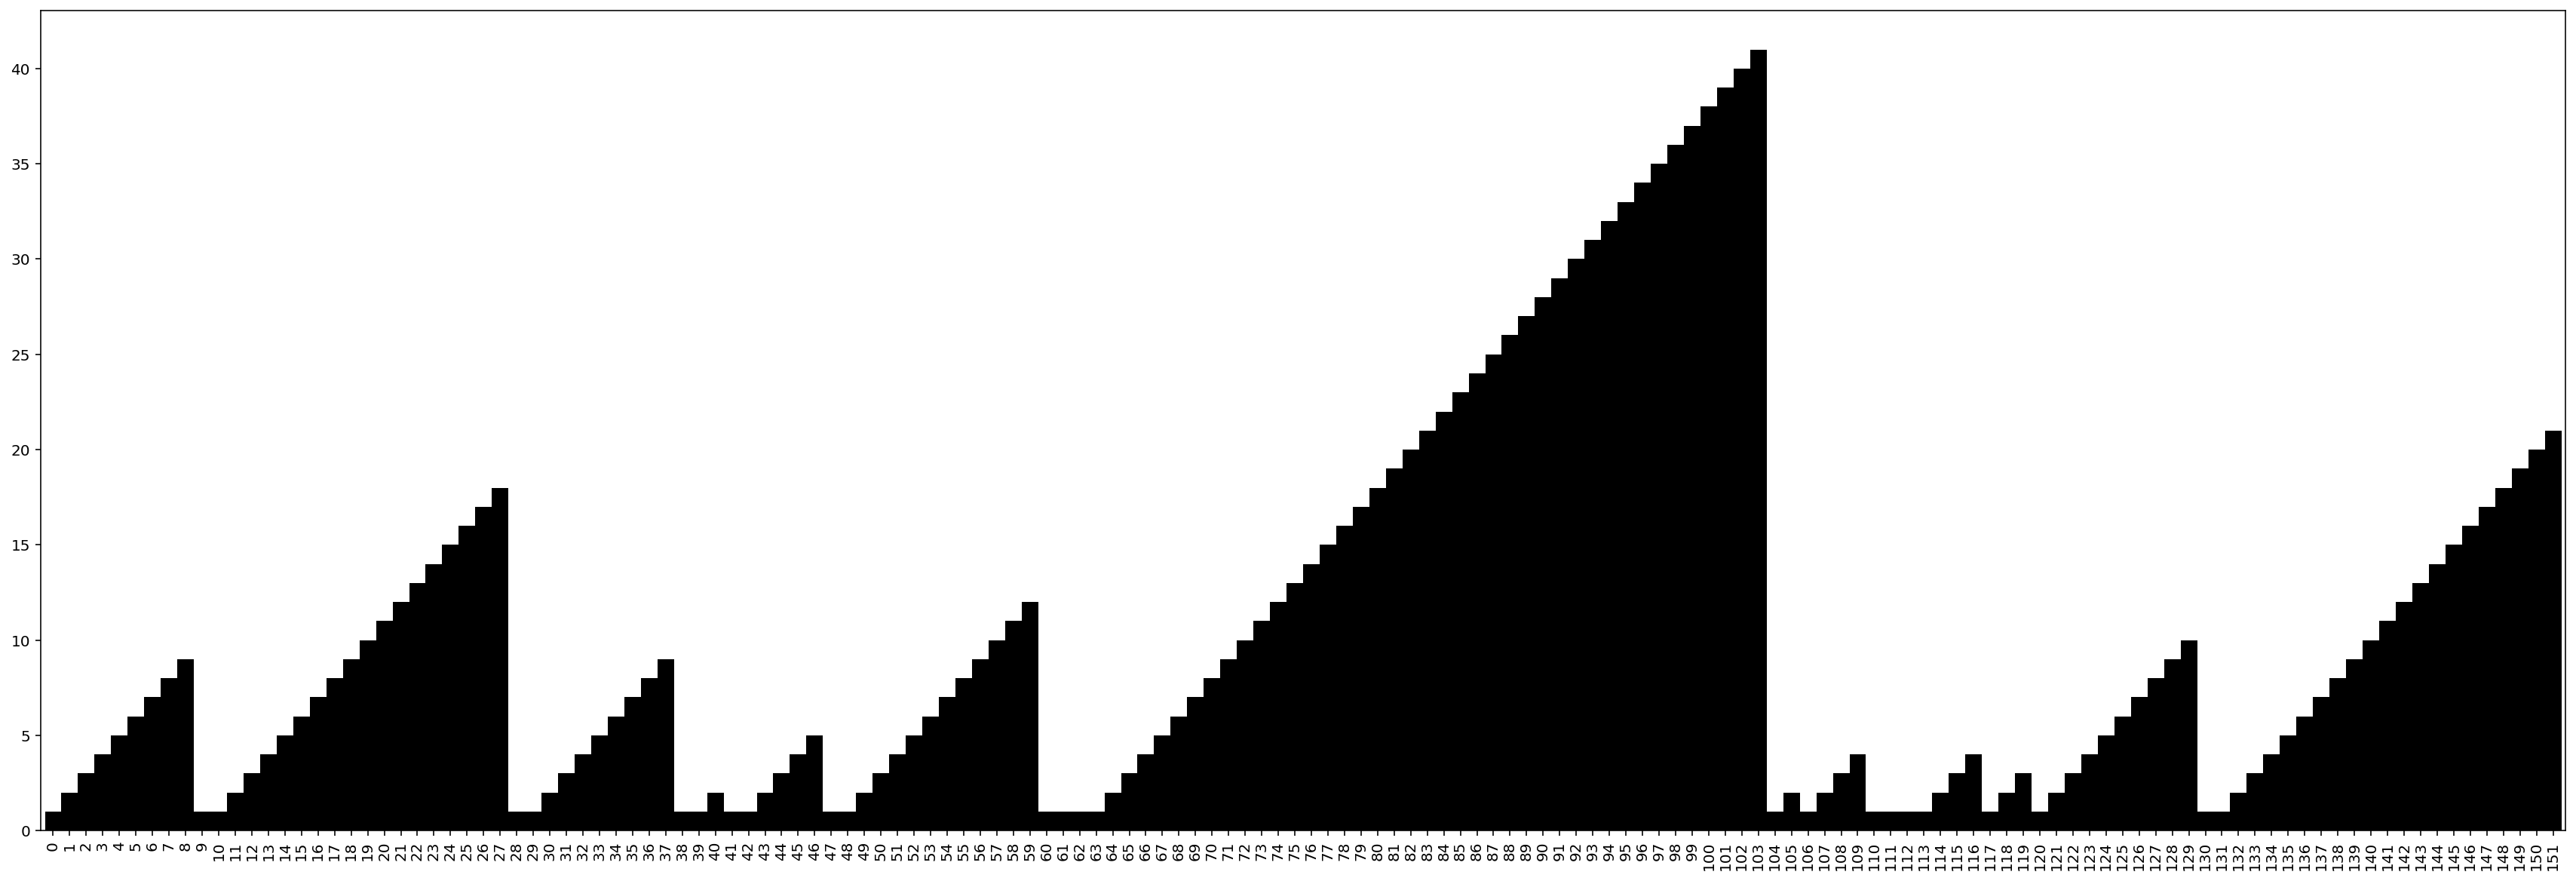

In [44]:
def plot_shots(shots):
    """
    Calculate and plot streak data.
    """
    streak = generate_streak_info(shots)
    
    fig, ax = plt.subplots(figsize=(30,10))
    streak['streak_counter'].plot.bar(ax=ax, color='black', width=1)
    plt.show()
    
plot_shots(durant_ft)

Make and Miss Streaks in different colours:

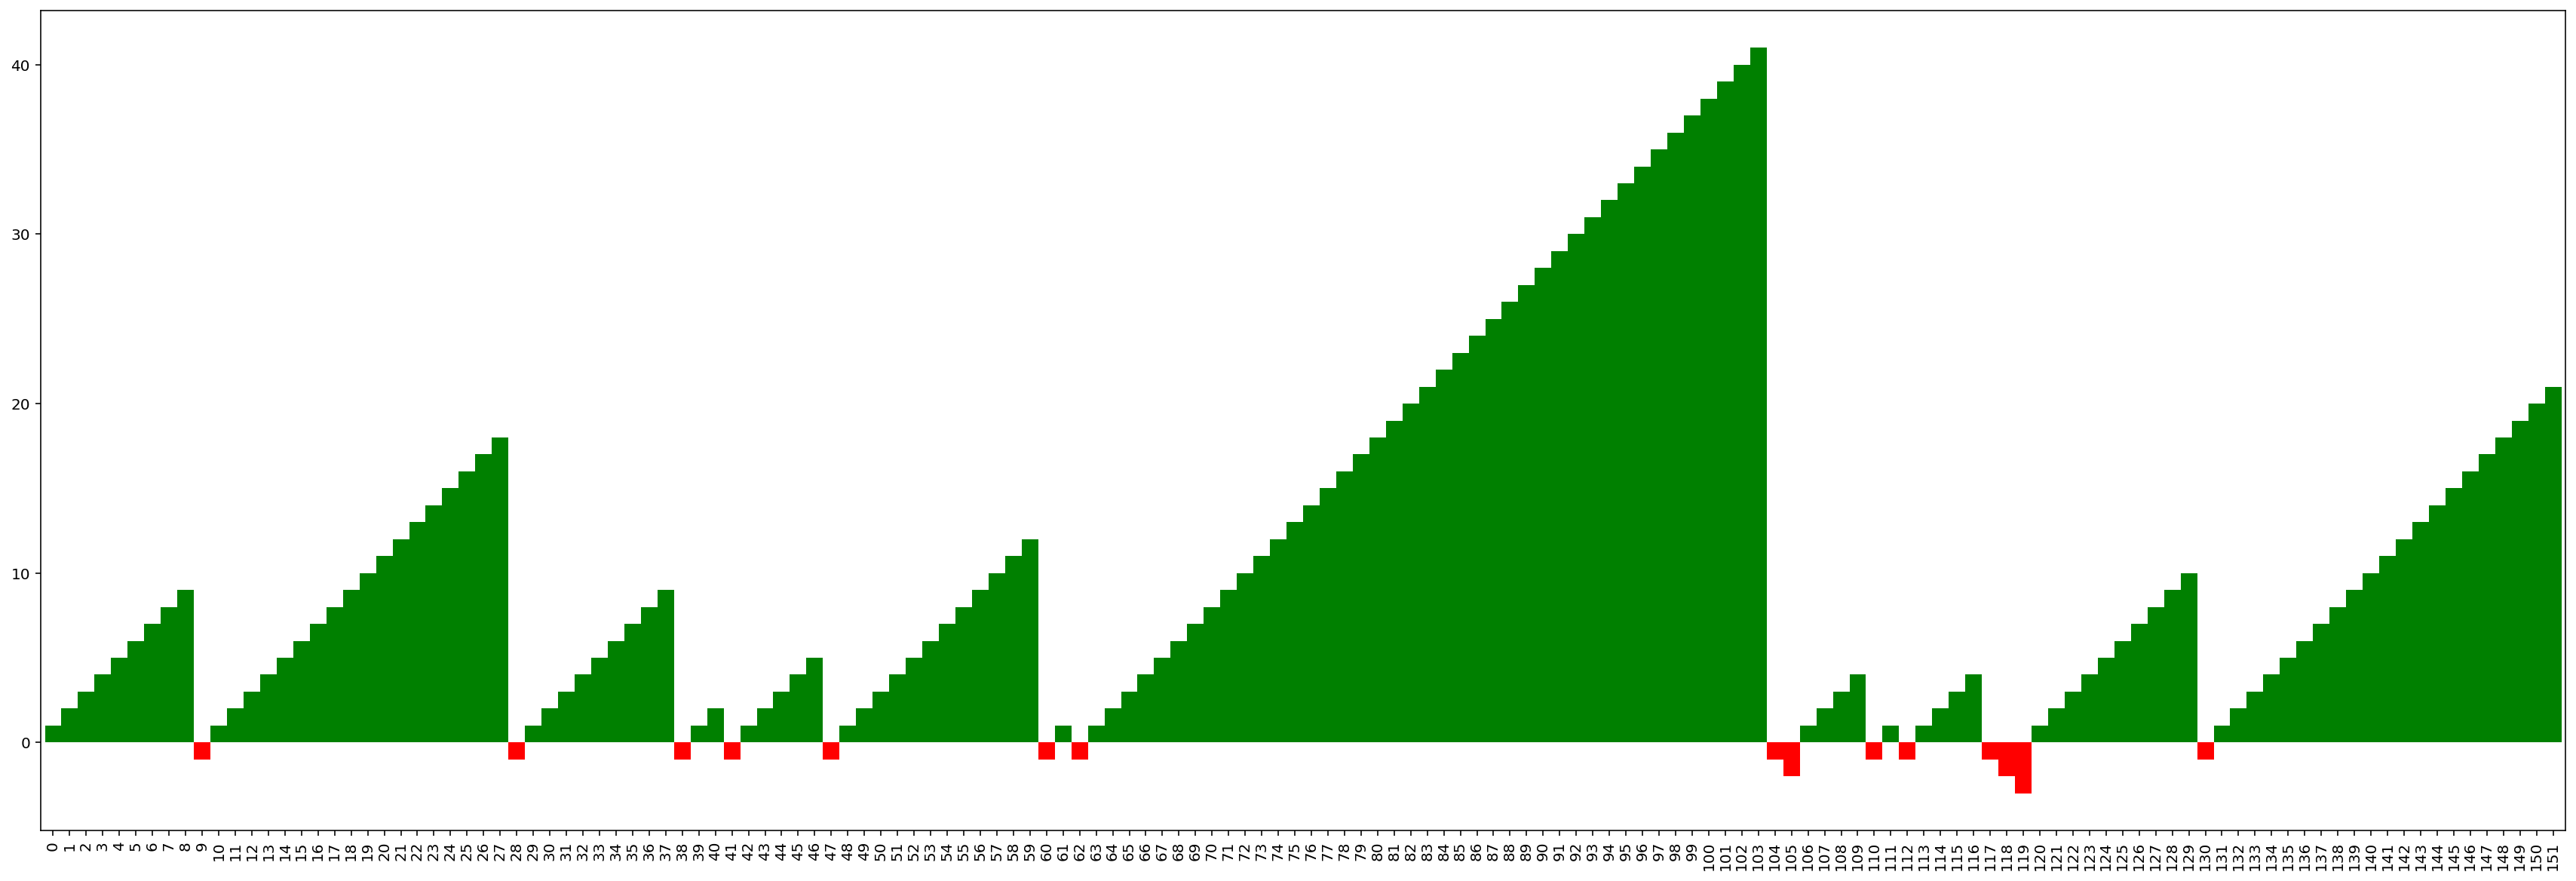

In [45]:
def plot_shots(shots):
    """
    Calculate and plot streak data.
    """
    
    # filter data into makes and misses
    streak = generate_streak_info(shots)
    streak.loc[streak['result'] == "make", "makes"] = streak['streak_counter']
    streak.loc[streak['result'] == "miss", "misses"] = -1 * streak['streak_counter']
    
    # plot the streaks
    fig, ax = plt.subplots(figsize=(30,10))
    streak['makes'].plot.bar(ax=ax, color='green', width=1)
    streak['misses'].plot.bar(ax=ax, color='red', width=1)

    plt.show()
    
plot_shots(durant_ft)

Setting different styling:

In [47]:
def plot_shots(shots):
    """
    Calculate and plot streak data.
    """
    
    # filter data into makes and misses
    streak = generate_streak_info(shots)
    streak.loc[streak['result'] == "make", "makes"] = streak['streak_counter']
    streak.loc[streak['result'] == "miss", "misses"] = -1 * streak['streak_counter']
    
    # plot the streaks
    fig, ax = plt.subplots(figsize=(30,10))
    streak['makes'].plot.bar(ax=ax, color='green', width=1)
    streak['misses'].plot.bar(ax=ax, color='red', width=1)
    
    ##################
    # NEW CODE BELOW #
    ##################
    
    # add a horizontal line at y=0
    plt.axhline(y=0, color='black', linewidth=5)
    
    # remove ticks from all sides
    plt.tick_params(axis='both',
                    bottom=False,
                    labelbottom=False,
                    left=False,
                    labelleft=False)
    
    # remove spine from top, bottom and right
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # set the left spine to a line width of 5
    ax.spines['left'].set_lw(5)

    plt.show()

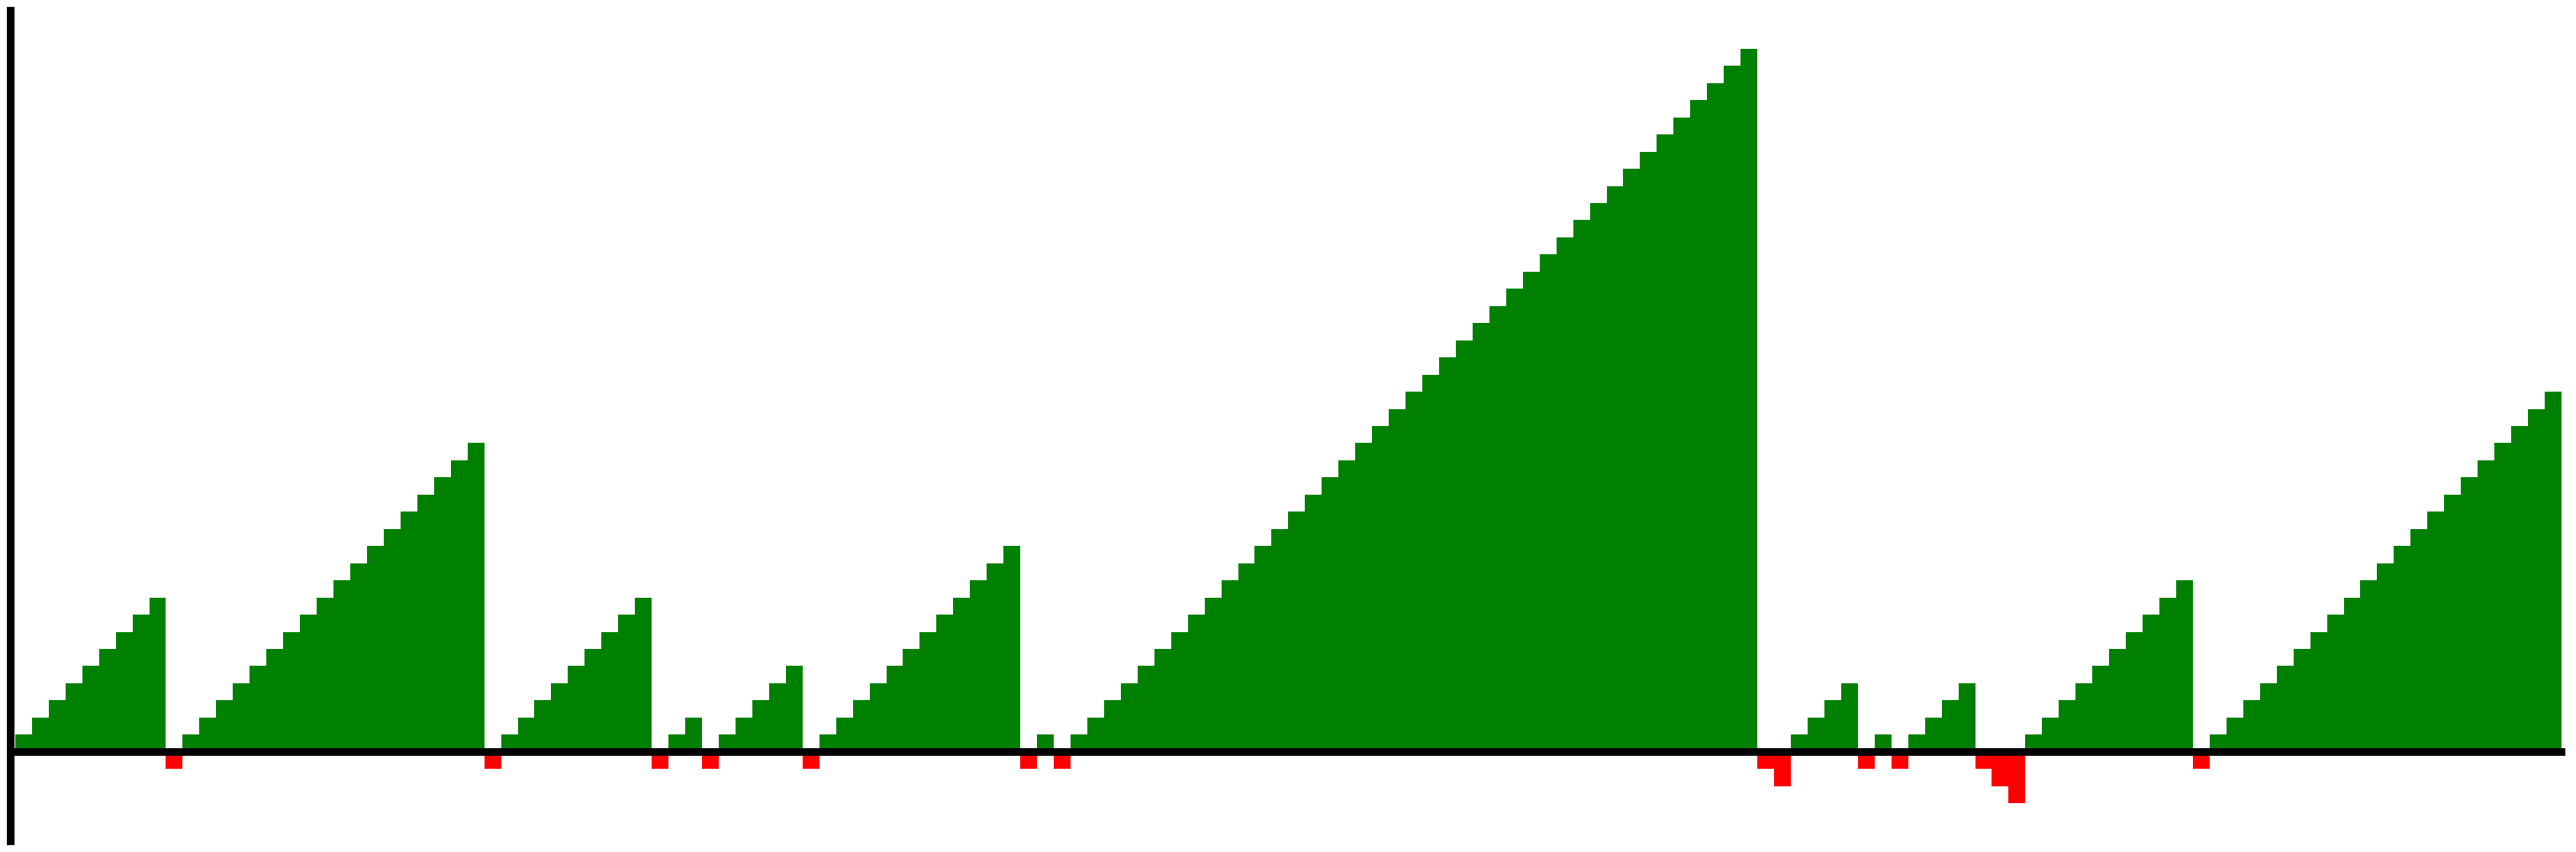

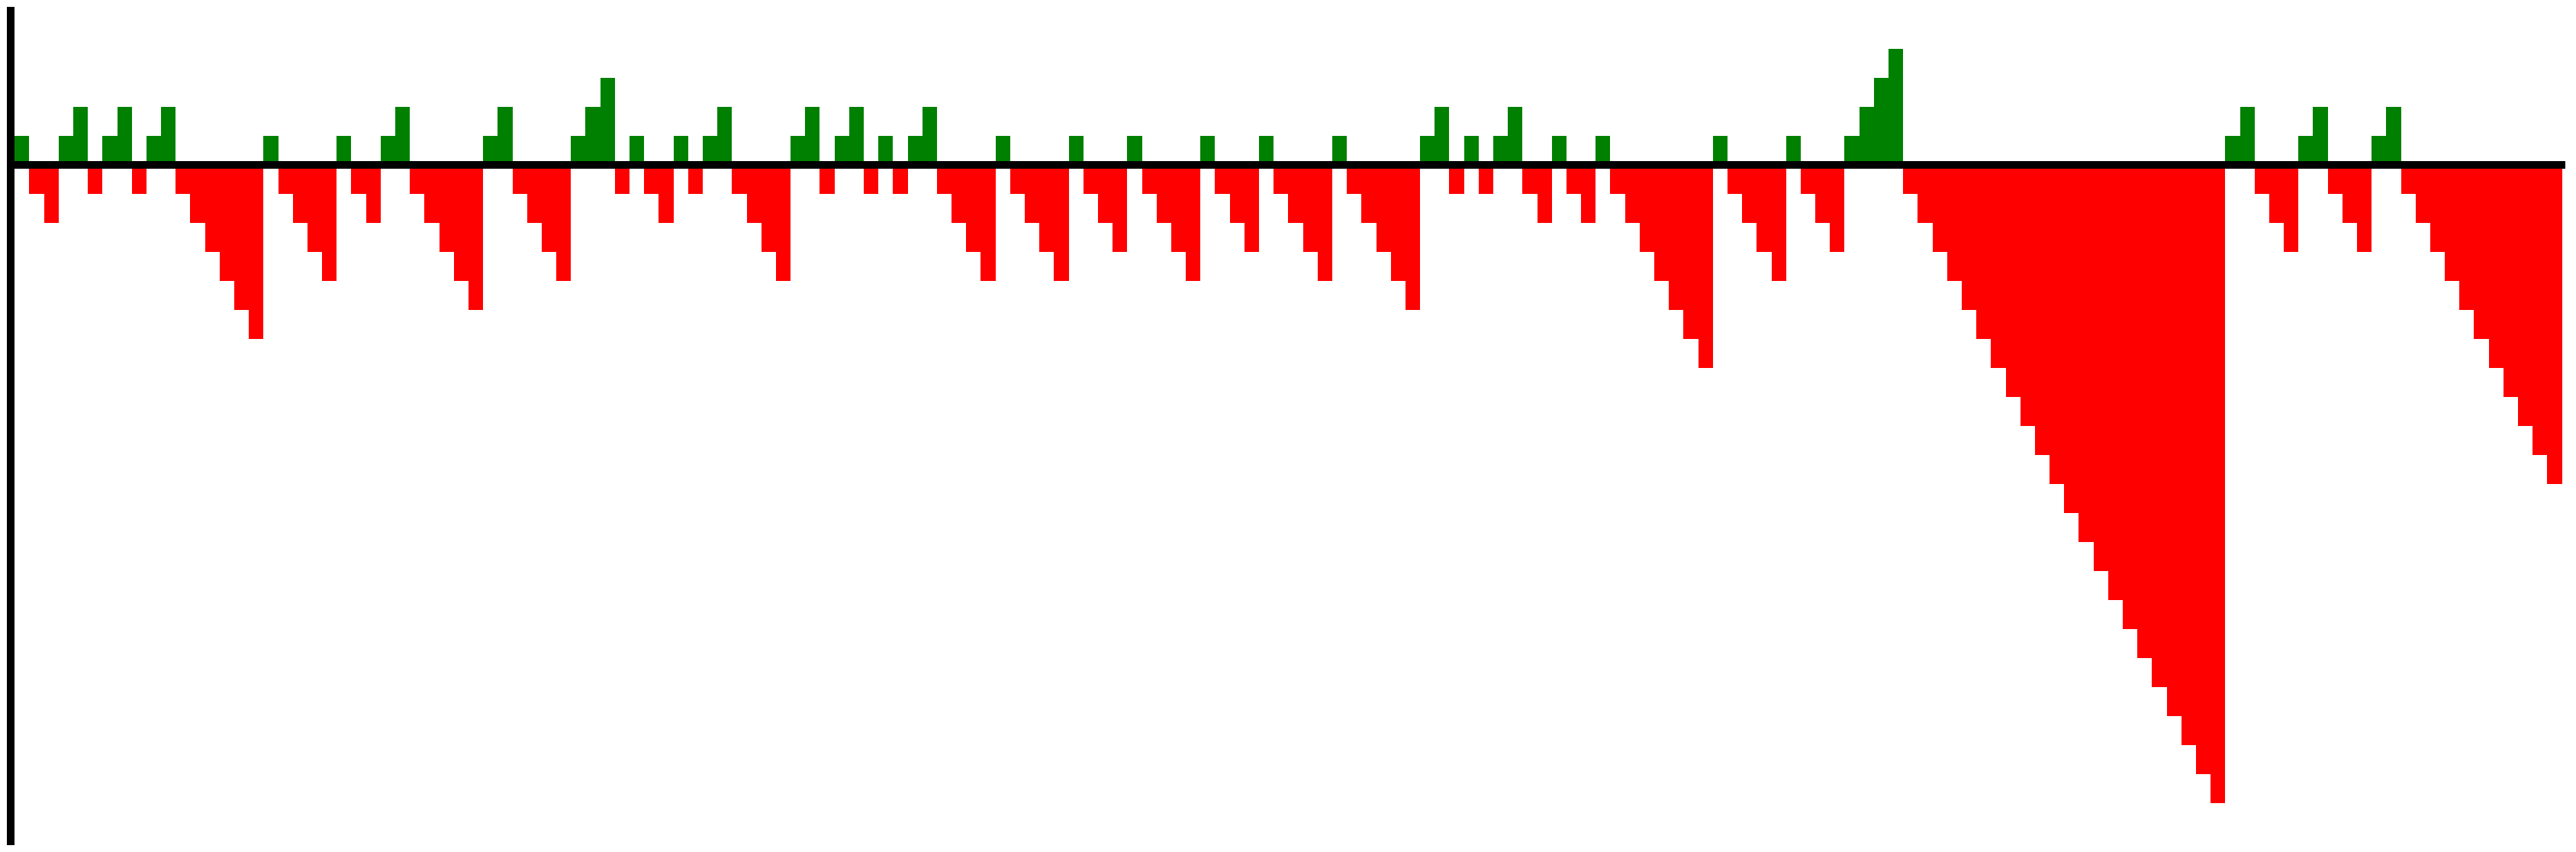

In [48]:
# New Durant plot + Harden 3-p shots
plot_shots(durant_ft)

harden_3pt = filter_shots("James Harden", "3PT")
plot_shots(harden_3pt)

Better viz syncing axis, adding background and labels:

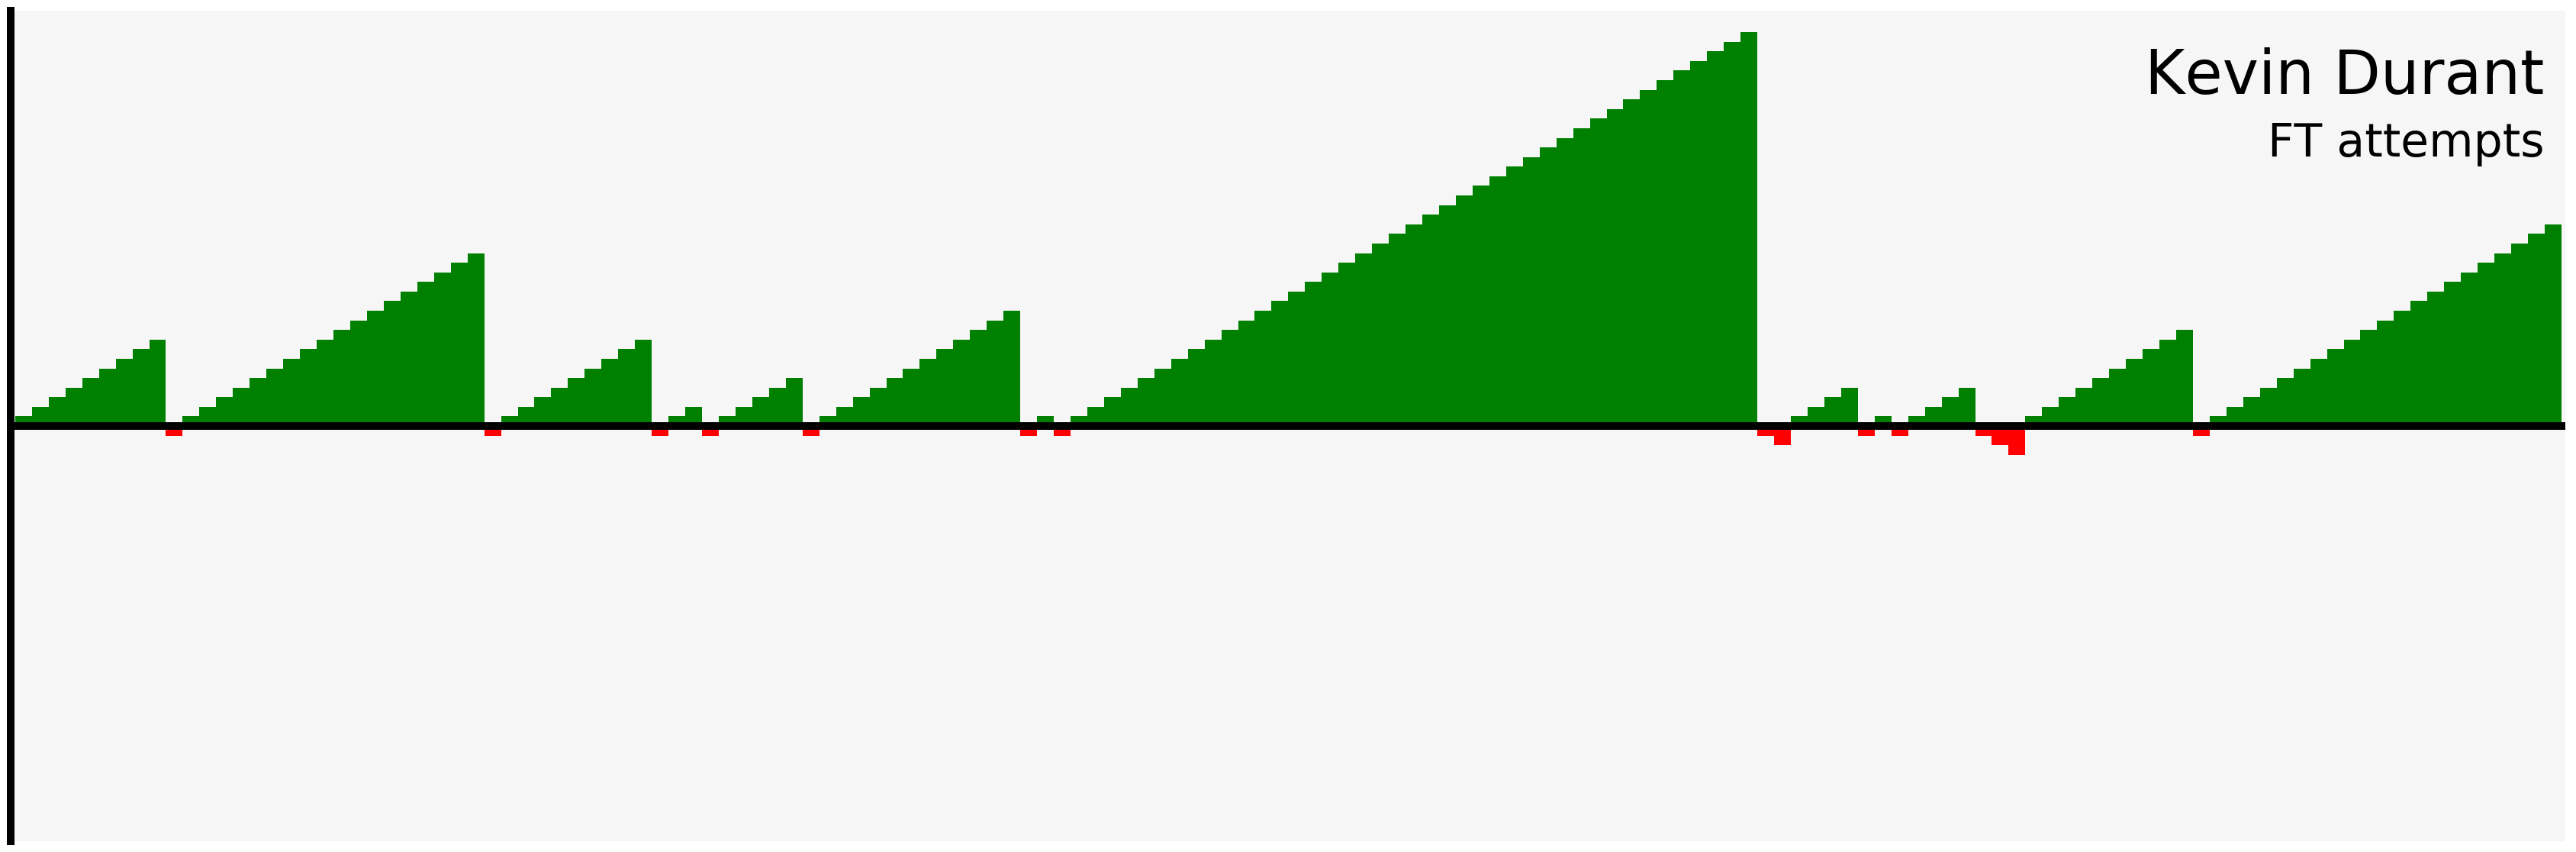

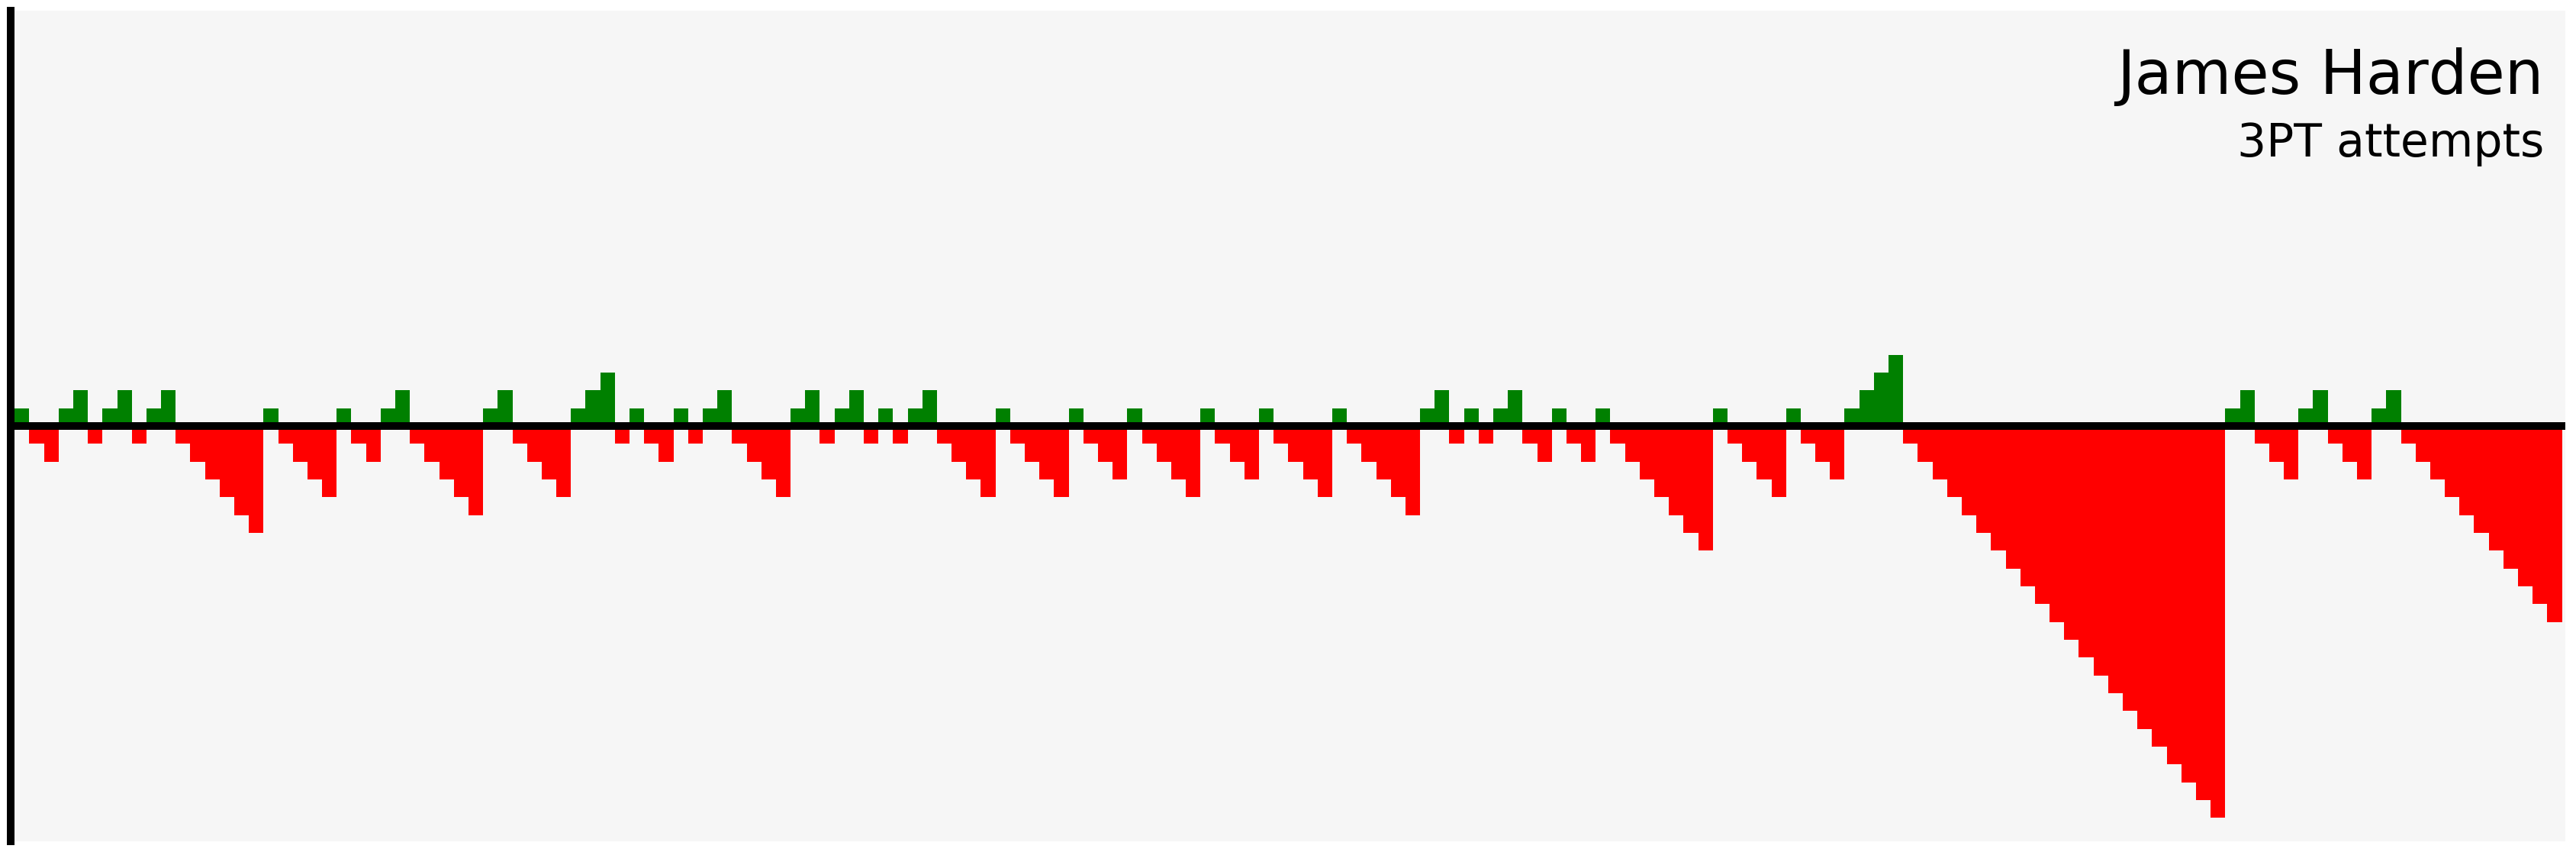

In [50]:
def plot_shots(shots, player_name, shot_info):
    """
    Calculate and plot streak data.
    """
    
    # filter data into makes and misses
    streak = generate_streak_info(shots)
    streak.loc[streak['result'] == "make", "makes"] = streak['streak_counter']
    streak.loc[streak['result'] == "miss", "misses"] = -1 * streak['streak_counter']
    
    # plot the streaks
    fig, ax = plt.subplots(figsize=(30,10))
    streak['makes'].plot.bar(ax=ax, color='green', width=1)
    streak['misses'].plot.bar(ax=ax, color='red', width=1)
    # add a horizontal line at y=0
    plt.axhline(y=0, color='black', linewidth=5)
    
    # remove ticks from all sides
    plt.tick_params(axis='both',
                    bottom=False,
                    labelbottom=False,
                    left=False,
                    labelleft=False)
    
    # remove spine from top, bottom and right
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # make the left spine have a line width of 5
    ax.spines['left'].set_lw(5)
    
    # calculate the largest of the y limits, and use that to
    # set symmetrical limits
    limit = np.abs(plt.ylim()).max()
    plt.ylim(-1*limit,limit)
    
    ##################
    # NEW CODE BELOW #
    ##################
    
    # add summary text 
    x = streak.shape[0] * 0.99
    y1 = limit * 0.8
    y2 = limit * 0.65
    ax.text(x, y1, player_name, horizontalalignment='right', fontsize=40)
    ax.text(x, y2, shot_info, horizontalalignment='right', fontsize=30)
    
    # add background shading
    rect_coords = (-.5, -1 * limit)
    rect_width = streak.shape[0] + .5
    rect_height = 2 * limit
    bg = plt.Rectangle(rect_coords,
                       rect_width,
                       rect_height,
                       color='#f6f6f6',
                       zorder=-1) 
    ax.add_patch(bg)
    
    plt.show()
    
plot_shots(durant_ft, "Kevin Durant", "FT attempts")
plot_shots(harden_3pt, "James Harden", "3PT attempts")

New function to filter and plot at the same time

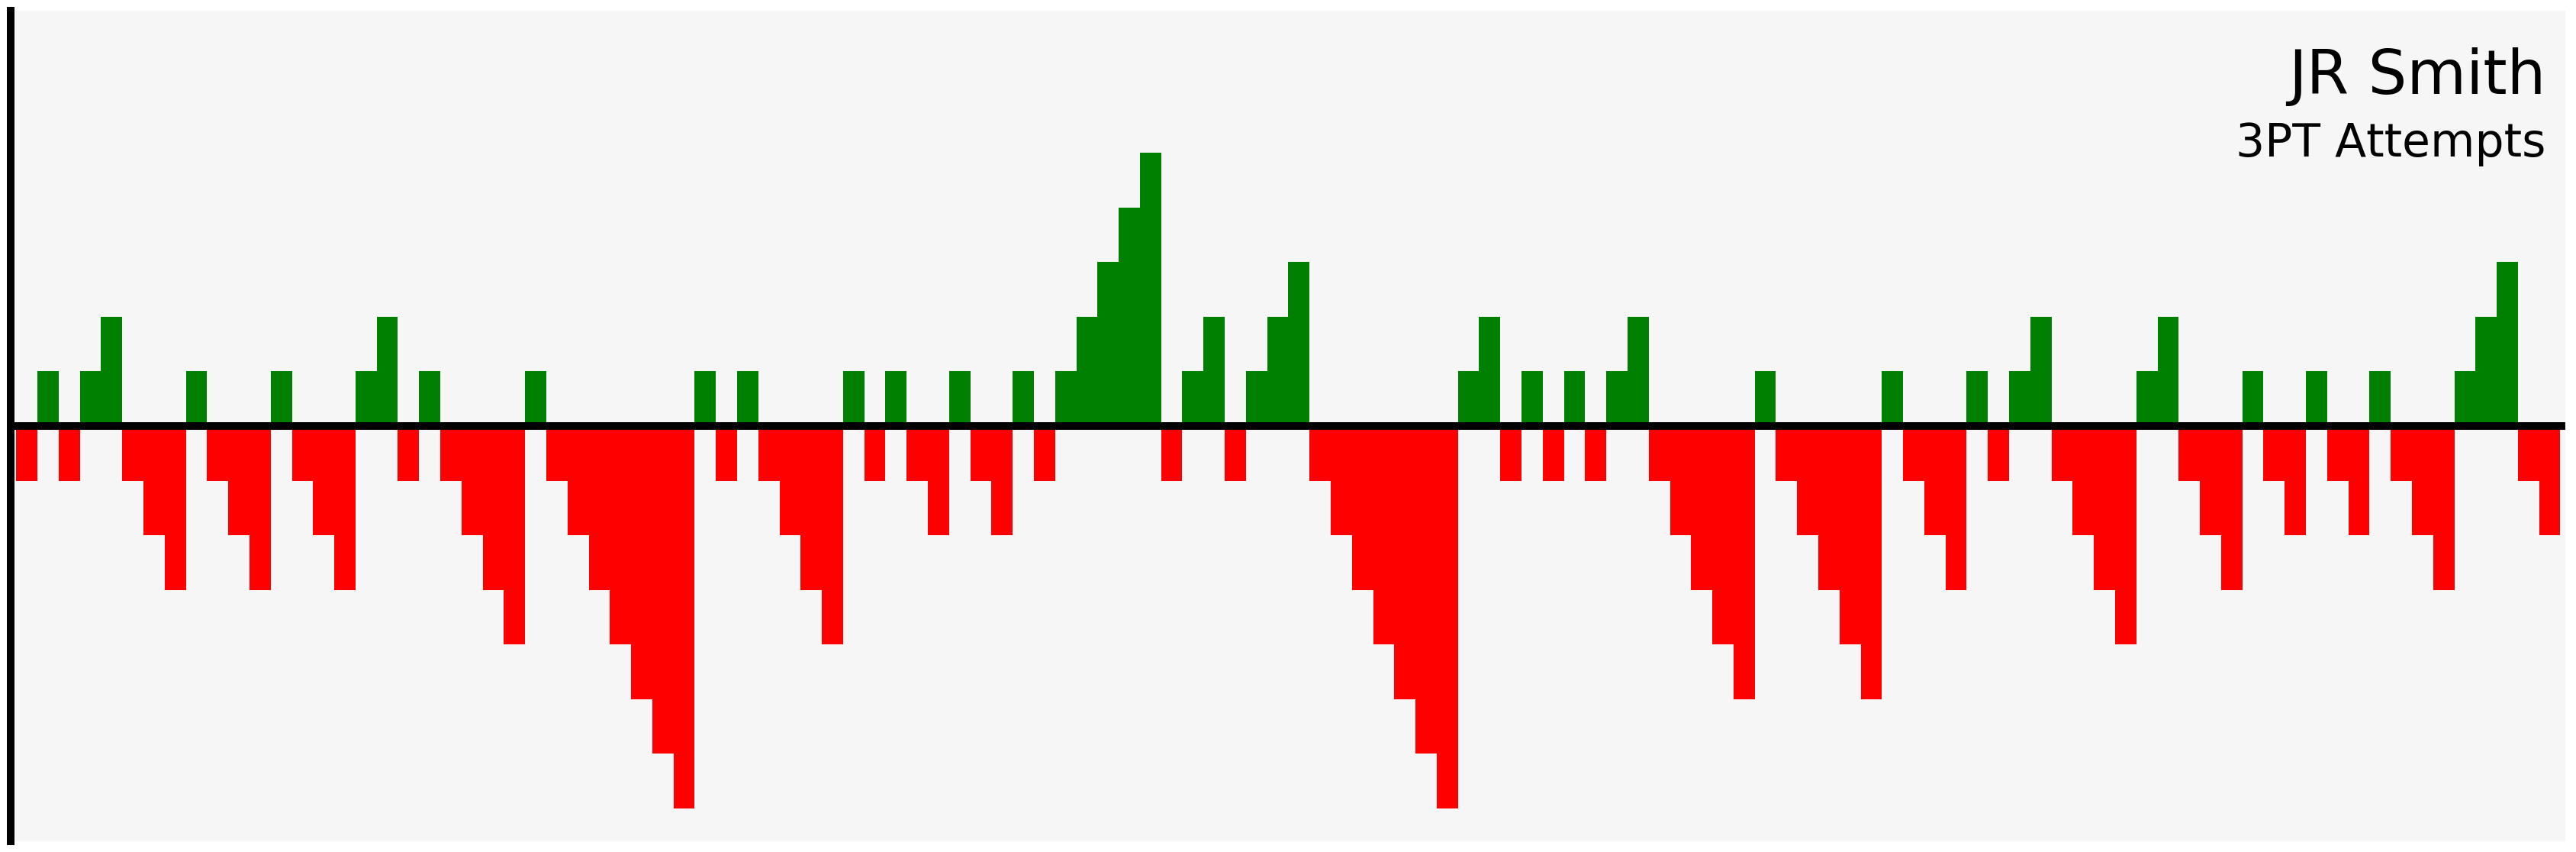

In [51]:
def filter_and_plot(name, shot_type):
    """
    Filter by player and shot type and then plot
    the resultant data.
    """
    shots = filter_shots(name, shot_type)
    label = f"{shot_type} Attempts"
    
    plot_shots(shots, name, label)

filter_and_plot("JR Smith", "3PT")

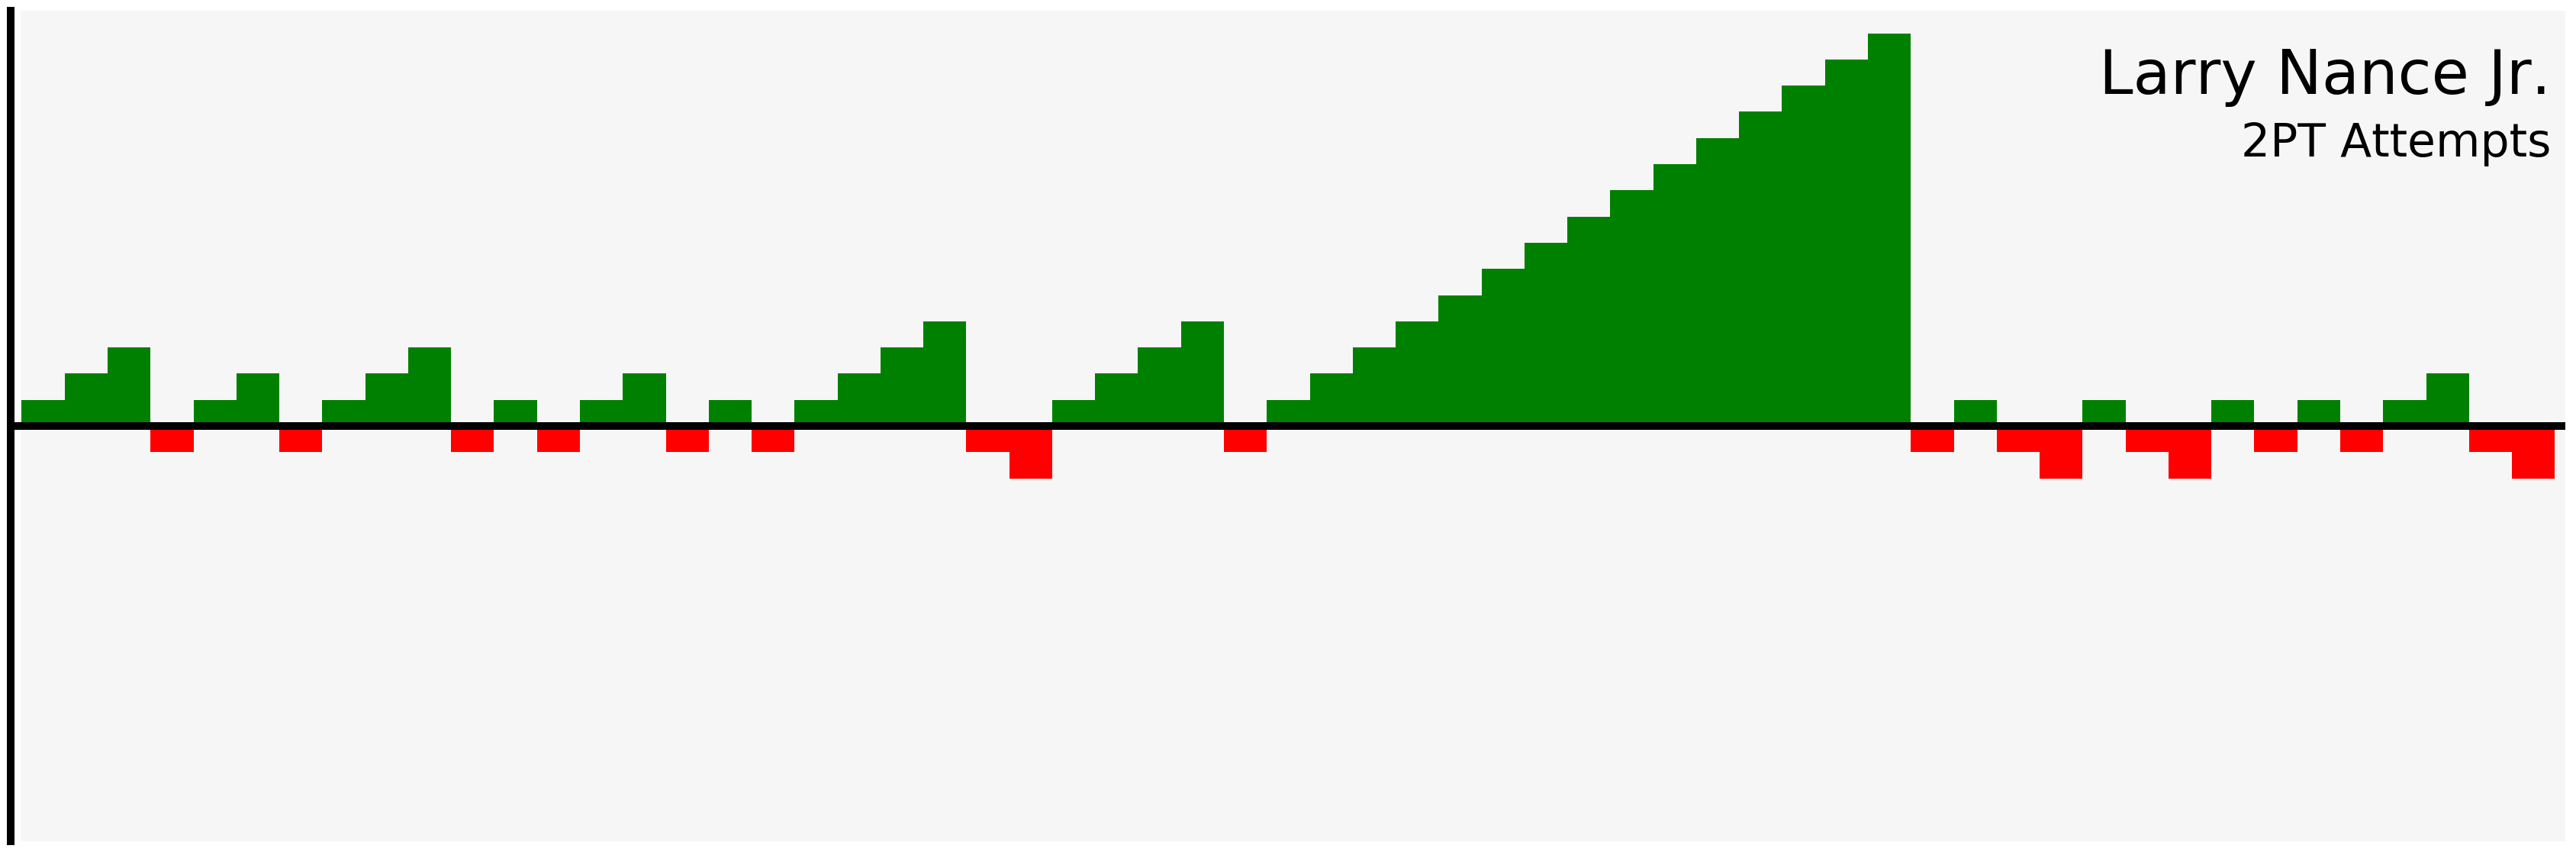

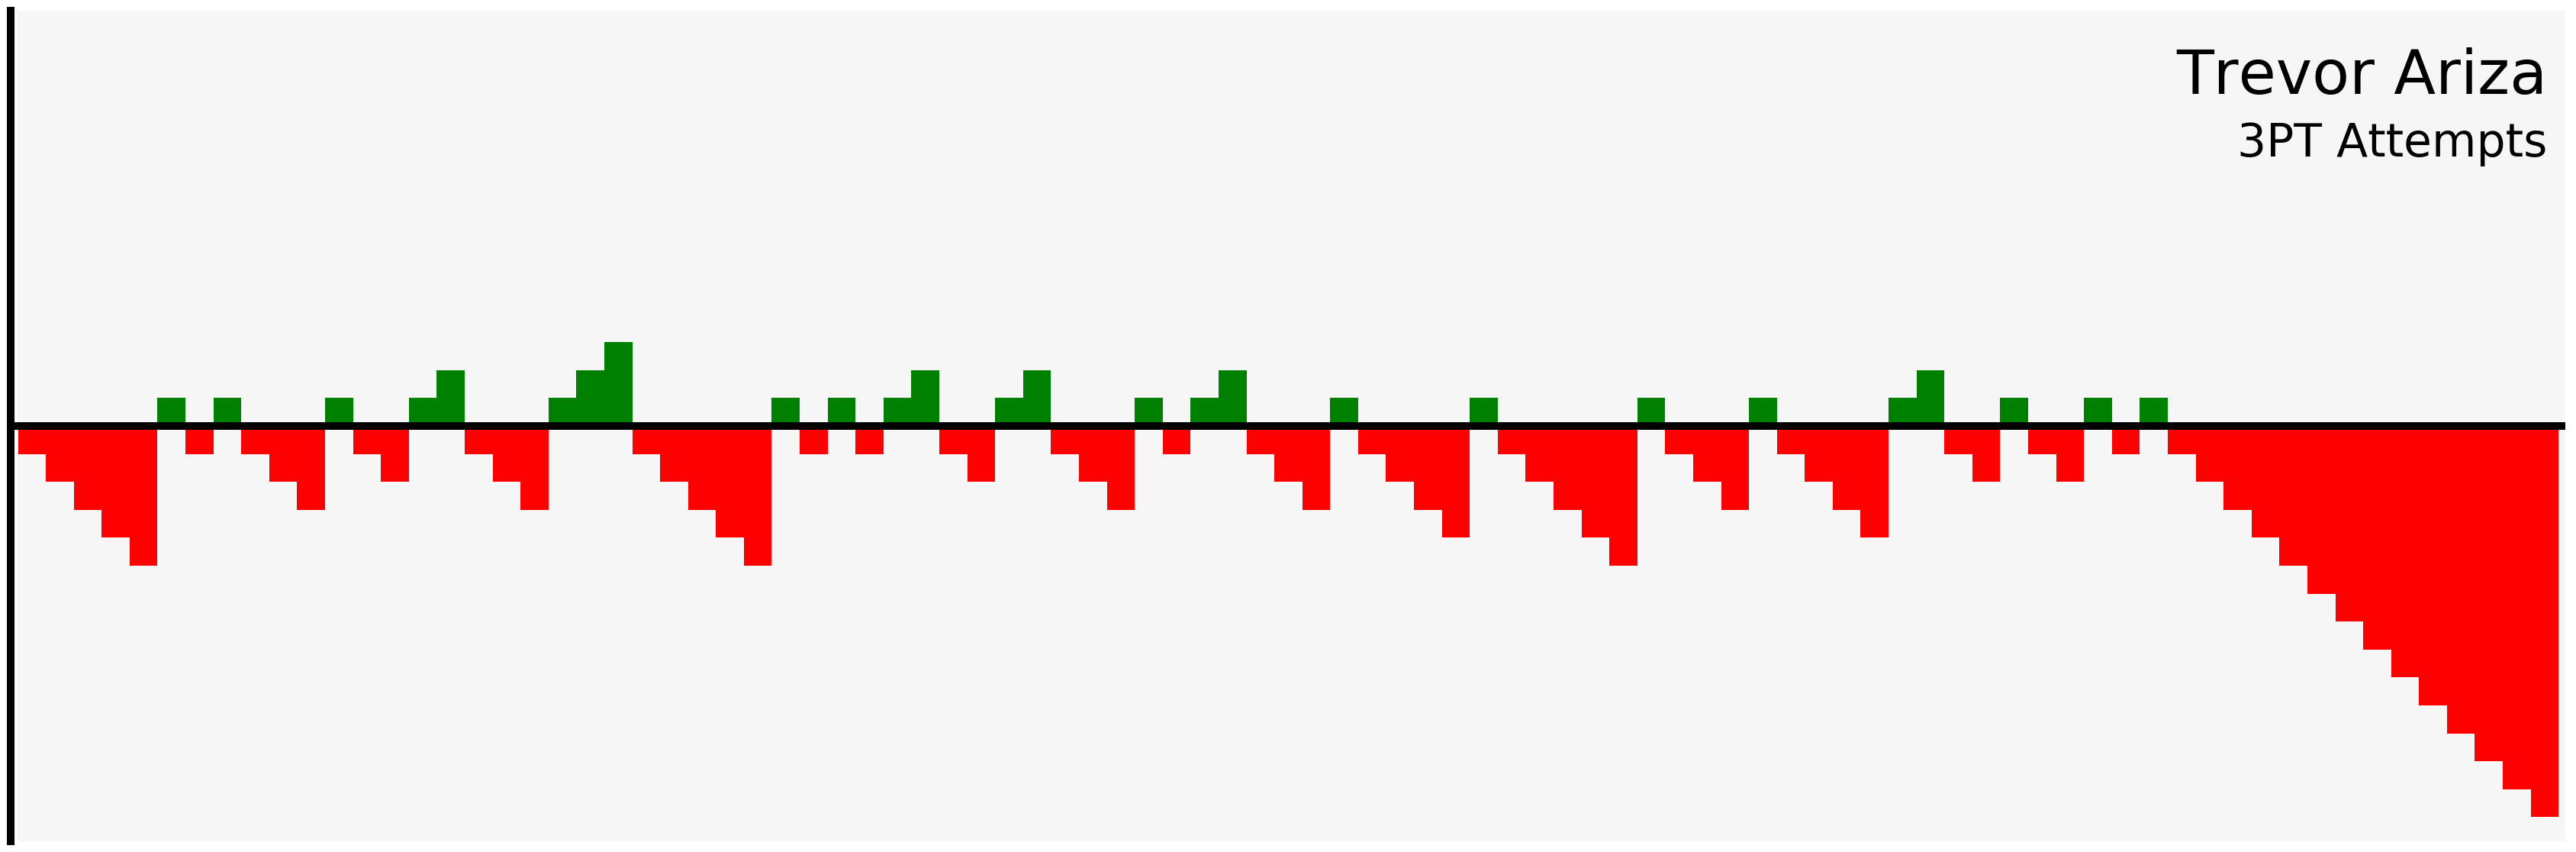

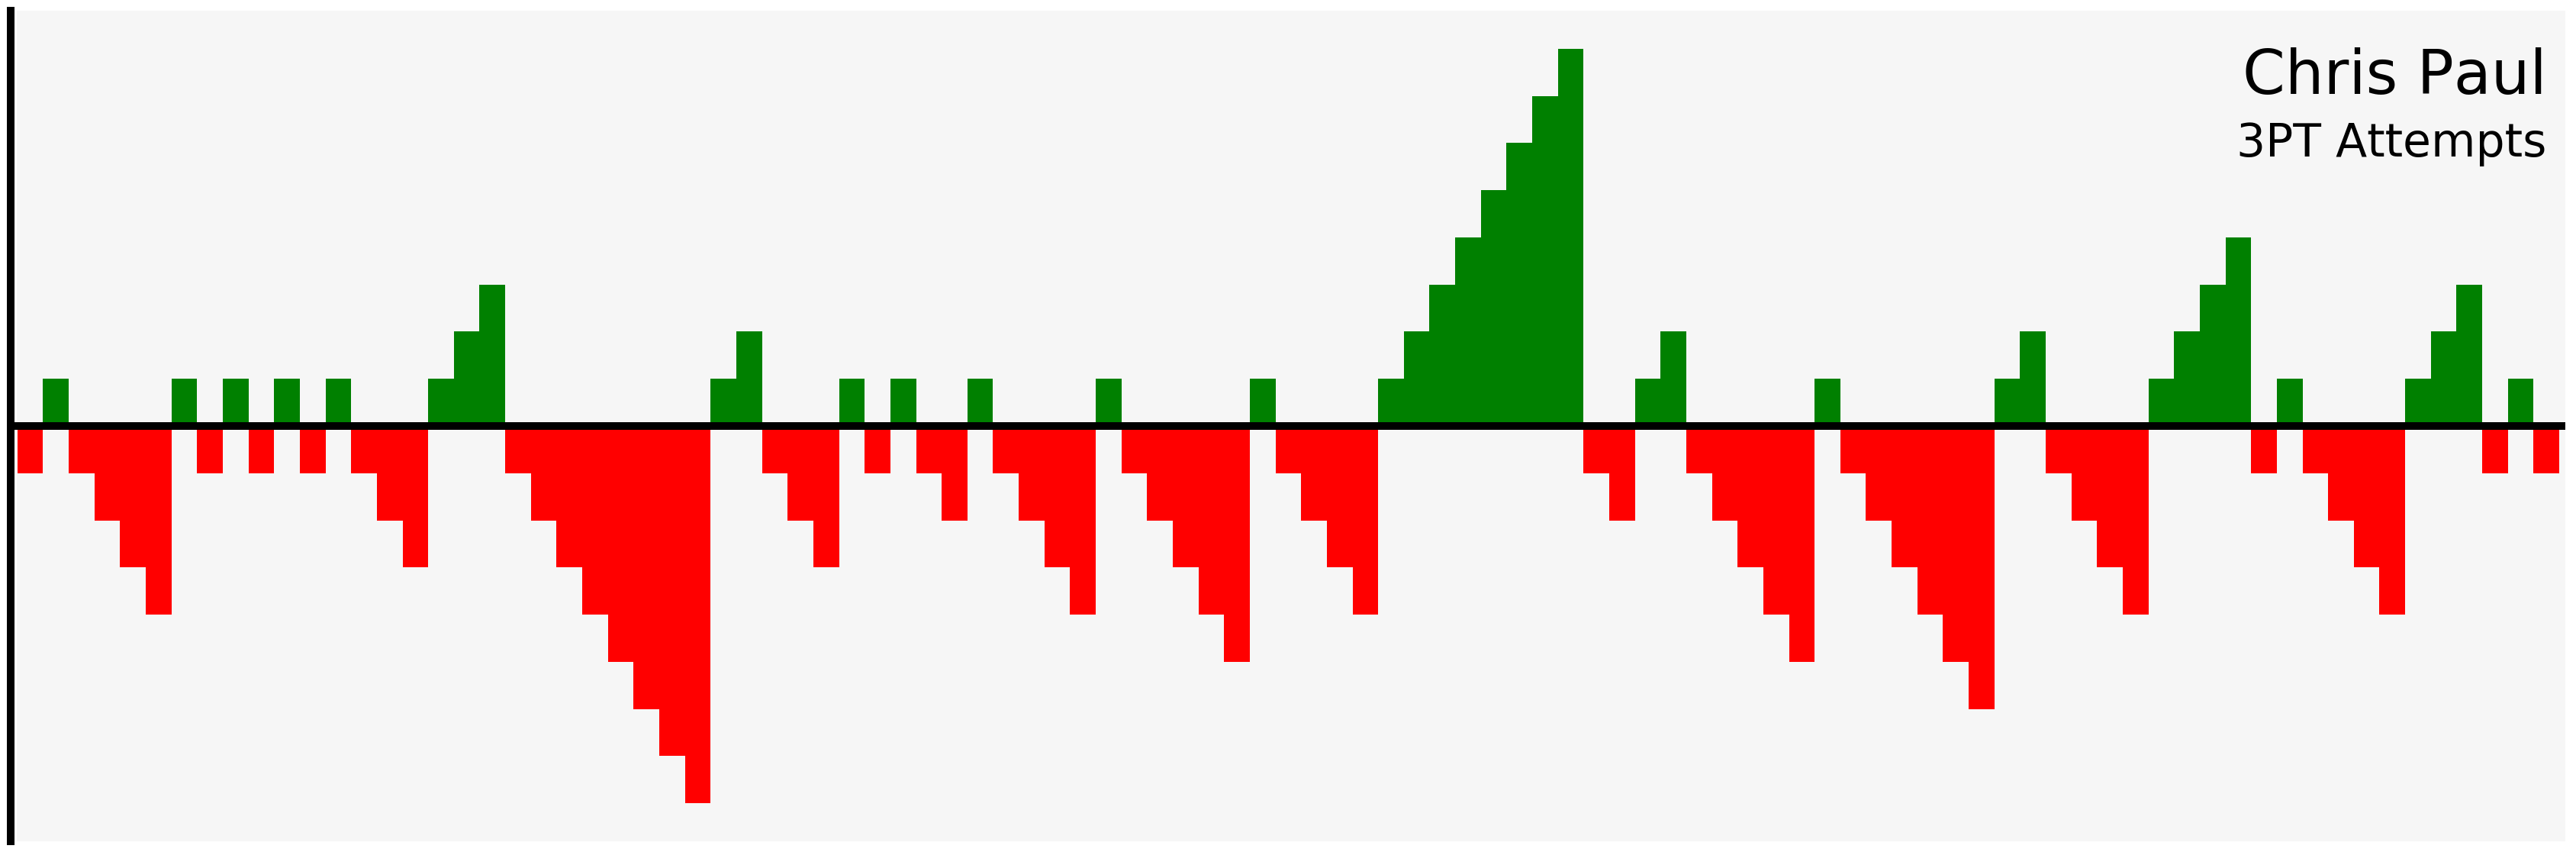

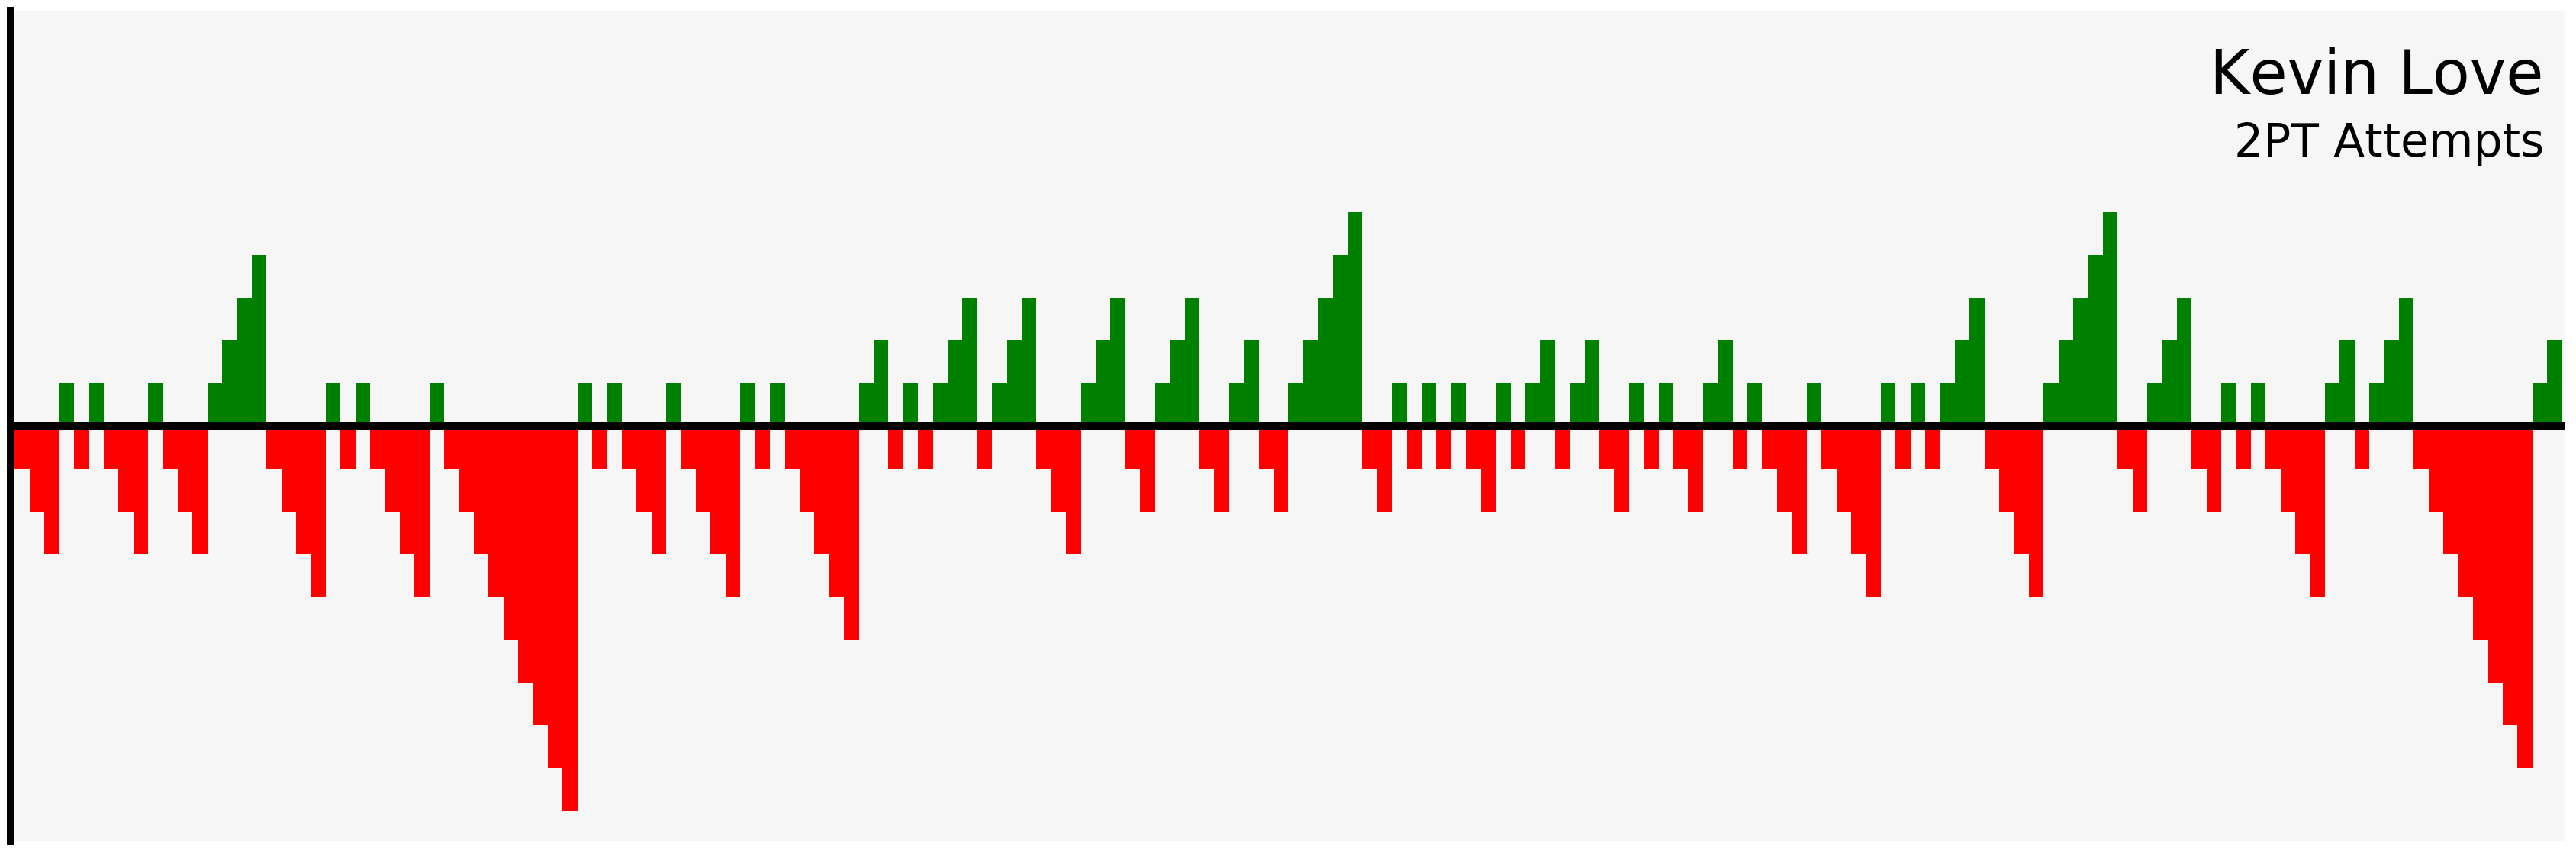

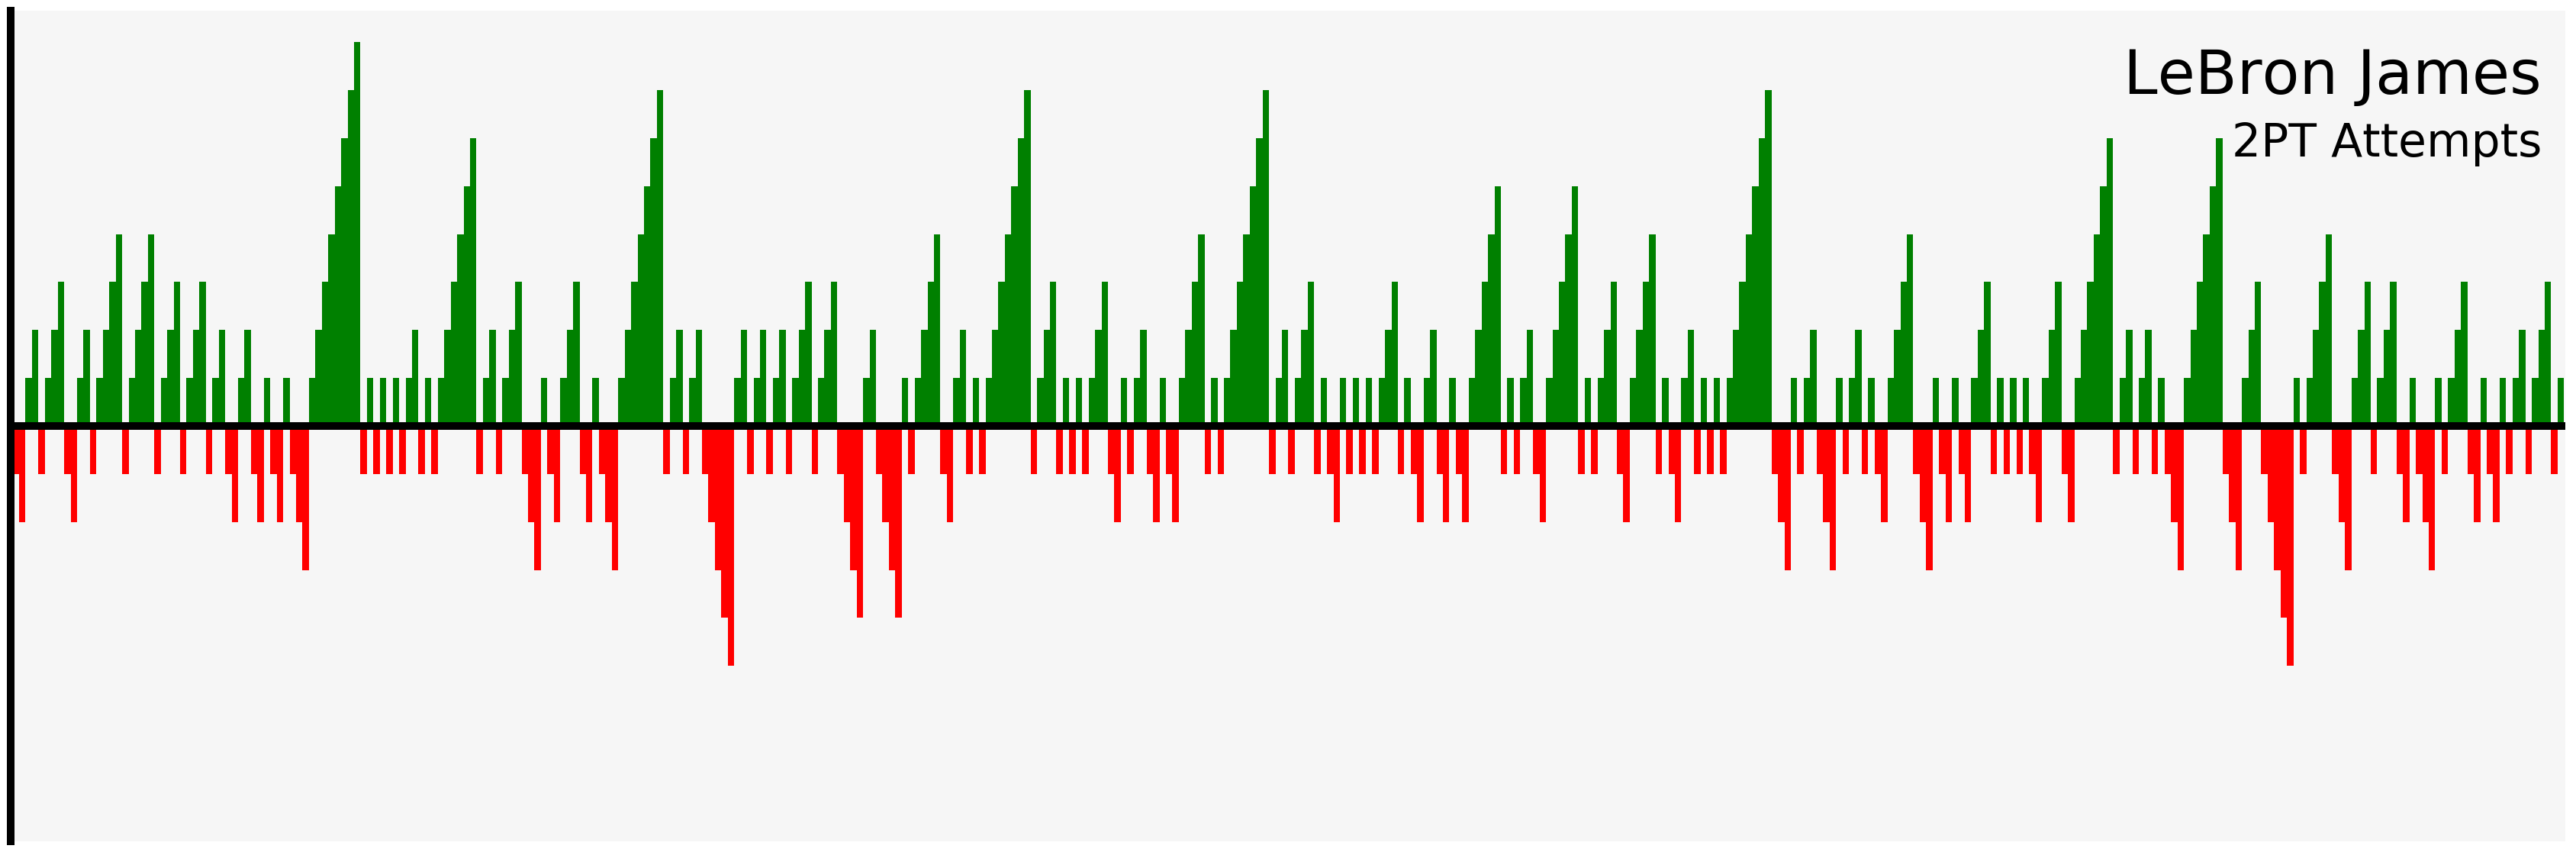

In [52]:
filter_and_plot("Larry Nance Jr.", "2PT")
filter_and_plot("Trevor Ariza", "3PT")
filter_and_plot("Chris Paul", "3PT")
filter_and_plot("Kevin Love", "2PT")
filter_and_plot("LeBron James", "2PT")